# Inspect Data

In [62]:
import sys
import time
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import tf_keras
import matplotlib.pyplot as plt
import tensorflow_model_optimization as tfmot

from matplotlib.colors import rgb2hex

from sklearn import svm
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.tree import plot_tree
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import cross_val_score, train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score

from tf_keras.regularizers import l2
from tf_keras.layers import Input, Dense, Dropout, BatchNormalization
from tf_keras.models import Sequential
from tf_keras.utils import to_categorical, plot_model
from tf_keras.optimizers import Adam
from tf_keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras_tuner import HyperModel
from keras_tuner.tuners import BayesianOptimization

'''from keras.regularizers import l2
from keras.layers import Input, Dense, Dropout, BatchNormalization
from keras.models import Sequential
from keras.utils import to_categorical, plot_model
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau'''

'from keras.regularizers import l2\nfrom keras.layers import Input, Dense, Dropout, BatchNormalization\nfrom keras.models import Sequential\nfrom keras.utils import to_categorical, plot_model\nfrom keras.optimizers import Adam\nfrom keras.callbacks import EarlyStopping, ReduceLROnPlateau'

## Loading dataset and creating dfs

In [2]:
# Load the feature names
features = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/features.txt', sep='\s+', header=None)

# Create unique feature names by combining the index and the feature name. This avoids an issue with duplicate entries
unique_column_names = [f"{row[0]}_{row[1]}" for index, row in features.iterrows()]

# Load X_train and X_test
X_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/X_train.txt', sep='\s+', header=None, names=unique_column_names)
X_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/X_test.txt', sep='\s+', header=None, names=unique_column_names)

# Load y_train and y_test
y_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/y_train.txt', sep='\s+', header=None)
y_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/y_test.txt', sep='\s+', header=None)

# From the test dataset, create a validation dataset
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, random_state=42)

# Load the different subjects
subject_train = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/train/subject_train.txt', sep='\s+', header=None)
subject_test = pd.read_csv('UCI HAR Dataset/UCI HAR Dataset/test/subject_test.txt', sep='\s+', header=None)

# Concatenate subject_train and X_train along the columns
X_train_with_subject = pd.concat([subject_train, X_train], axis=1)

# Optionally, name the columns for clarity (e.g., "Subject" for the subject column)
X_train_with_subject.columns = ['subject'] + unique_column_names
X_train_with_subject

subject  1_tBodyAcc-mean()-X  2_tBodyAcc-mean()-Y  3_tBodyAcc-mean()-Z  \
0           1             0.288585            -0.020294            -0.132905   
1           1             0.278419            -0.016411            -0.123520   
2           1             0.279653            -0.019467            -0.113462   
3           1             0.279174            -0.026201            -0.123283   
4           1             0.276629            -0.016570            -0.115362   
...       ...                  ...                  ...                  ...   
7347       30             0.299665            -0.057193            -0.181233   
7348       30             0.273853            -0.007749            -0.147468   
7349       30             0.273387            -0.017011            -0.045022   
7350       30             0.289654            -0.018843            -0.158281   
7351       30             0.351503            -0.012423            -0.203867   

      4_tBodyAcc-std()-X  5_tBodyAcc-std()-Y  6_tBodyAcc-std()-Z  \
0              -0.995279           -0.983111           -0.913526   
1              -0.998245           -0.975300           -0.960322   
2              -0.995380           -0.967187           -0.978944   
3              -0.996091           -0.983403           -0.990675   
4              -0.998139           -0.980817           -0.990482   
...                  ...                 ...                 ...   
7347           -0.195387            0.039905            0.077078   
7348           -0.235309            0.004816            0.059280   
7349           -0.218218           -0.103822            0.274533   
7350           -0.219139           -0.111412            0.268893   
7351           -0.269270           -0.087212            0.177404   

      7_tBodyAcc-mad()-X  8_tBodyAcc-mad()-Y  9_tBodyAcc-mad()-Z  ...  \
0              -0.995112           -0.983185           -0.923527  ...   
1              -0.998807           -0.974914           -0.957686  ...   
2              -0.996520           -0.963668           -0.977469  ...   
3              -0.997099           -0.982750           -0.989302  ...   
4              -0.998321           -0.979672           -0.990441  ...   
...                  ...                 ...                 ...  ...   
7347           -0.282301            0.043616            0.060410  ...   
7348           -0.322552           -0.029456            0.080585  ...   
7349           -0.304515           -0.098913            0.332584  ...   
7350           -0.310487           -0.068200            0.319473  ...   
7351           -0.377404           -0.038678            0.229430  ...   

      552_fBodyBodyGyroJerkMag-meanFreq()  \
0                               -0.074323   
1                                0.158075   
2                                0.414503   
3                                0.404573   
4                                0.087753   
...                                   ...   
7347                            -0.070157   
7348                             0.165259   
7349                             0.195034   
7350                             0.013865   
7351                            -0.058402   

      553_fBodyBodyGyroJerkMag-skewness()  \
0                               -0.298676   
1                               -0.595051   
2                               -0.390748   
3                               -0.117290   
4                               -0.351471   
...                                   ...   
7347                            -0.588433   
7348                            -0.390738   
7349                             0.025145   
7350                             0.063907   
7351                            -0.387052   

      554_fBodyBodyGyroJerkMag-kurtosis()  555_angle(tBodyAccMean,gravity)  \
0                               -0.710304                        -0.112754   
1                               -0.861499                         0.053477   
2                               -0.

## Checking Class distributions

In [3]:
# Create a mapping for numerical labels
label_mapping = {
    1: 'Walking',
    2: 'Walking Upstairs',
    3: 'Walking Downstairs',
    4: 'Sitting',
    5: 'Standing',
    6: 'Laying'
}

# Create a df that contains both numerical and catagorical labels. Useful for plotting graphs
y_train_labels = y_train.copy()
y_train_labels['Descriptive Label'] = y_train_labels[0].replace(label_mapping)

y_test_labels = y_test.copy()
y_test_labels['Descriptive Label'] = y_test_labels[0].replace(label_mapping)

y_val_labels = y_val.copy()
y_val_labels['Descriptive Label'] = y_val_labels[0].replace(label_mapping)

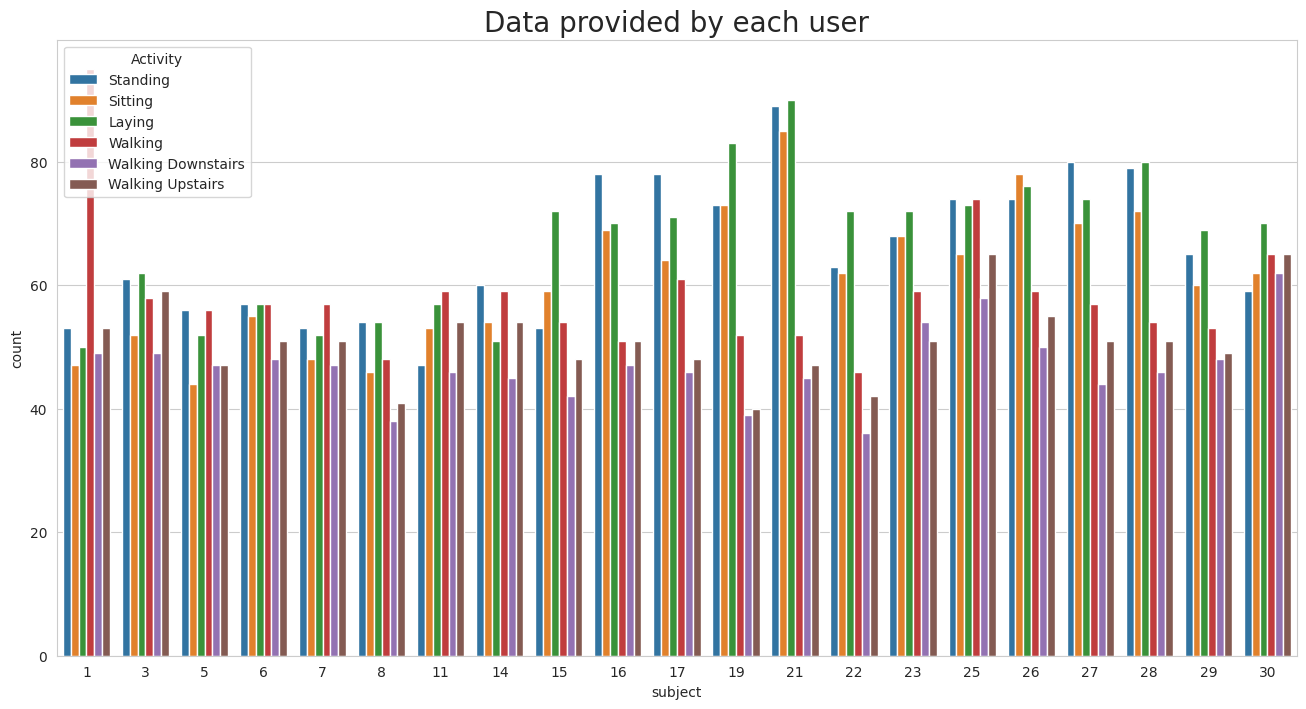

In [4]:
train = pd.concat([X_train_with_subject, y_train_labels], axis=1)

# Optionally, name the label columns for clarity
train.columns = list(X_train_with_subject.columns) + ['Numerical Label', 'Activity']

sns.set_style('whitegrid')
plt.rcParams['font.family'] = 'Dejavu Sans'
plt.figure(figsize=(16,8))
plt.title('Data provided by each user', fontsize=20)
sns.countplot(x='subject',hue='Activity', data = train)
plt.show()

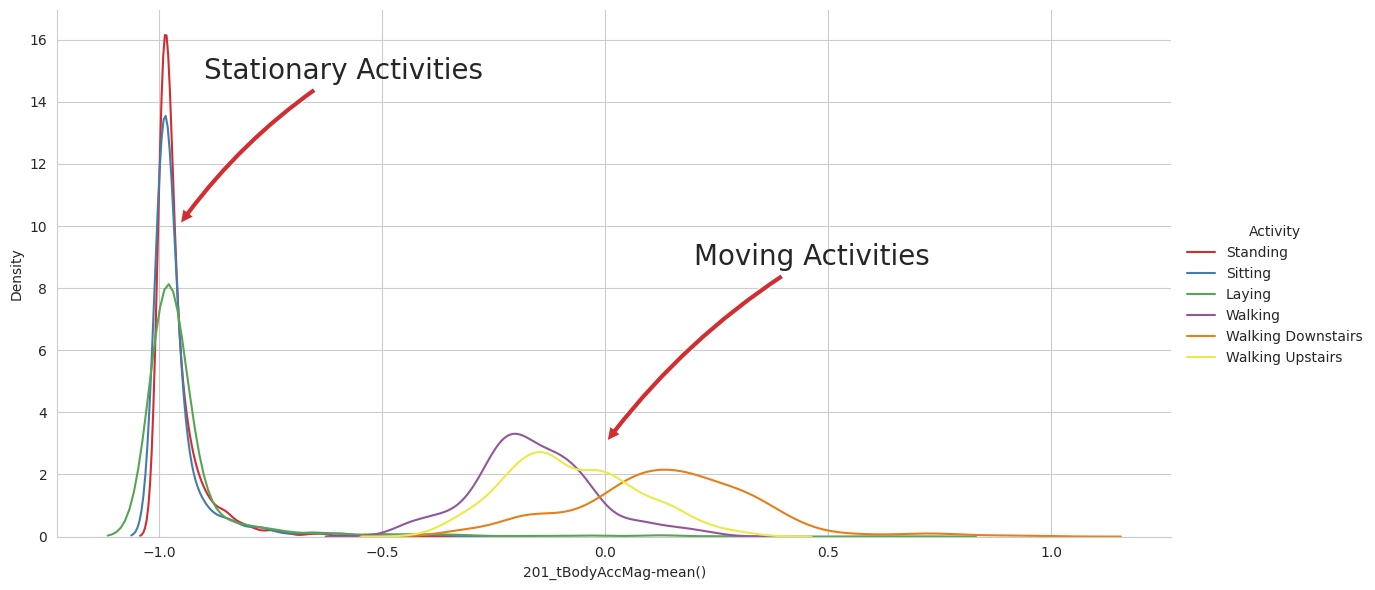

In [5]:
sns.set_palette("Set1", desat=0.80)
facetgrid = sns.FacetGrid(train, hue='Activity', height=6, aspect=2)
facetgrid.map(sns.kdeplot,'201_tBodyAccMag-mean()',).add_legend()
plt.annotate("Stationary Activities", xy=(-0.956,10), xytext=(-0.9, 15), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))

plt.annotate("Moving Activities", xy=(0,3), xytext=(0.2, 9), size=20,\
            va='center', ha='left',\
            arrowprops=dict(arrowstyle="simple",connectionstyle="arc3,rad=0.1"))
plt.show()

In [6]:
train.head()

subject  1_tBodyAcc-mean()-X  2_tBodyAcc-mean()-Y  3_tBodyAcc-mean()-Z  \
0        1             0.288585            -0.020294            -0.132905   
1        1             0.278419            -0.016411            -0.123520   
2        1             0.279653            -0.019467            -0.113462   
3        1             0.279174            -0.026201            -0.123283   
4        1             0.276629            -0.016570            -0.115362   

   4_tBodyAcc-std()-X  5_tBodyAcc-std()-Y  6_tBodyAcc-std()-Z  \
0           -0.995279           -0.983111           -0.913526   
1           -0.998245           -0.975300           -0.960322   
2           -0.995380           -0.967187           -0.978944   
3           -0.996091           -0.983403           -0.990675   
4           -0.998139           -0.980817           -0.990482   

   7_tBodyAcc-mad()-X  8_tBodyAcc-mad()-Y  9_tBodyAcc-mad()-Z  ...  \
0           -0.995112           -0.983185           -0.923527  ...   
1           -0.998807           -0.974914           -0.957686  ...   
2           -0.996520           -0.963668           -0.977469  ...   
3           -0.997099           -0.982750           -0.989302  ...   
4           -0.998321           -0.979672           -0.990441  ...   

   554_fBodyBodyGyroJerkMag-kurtosis()  555_angle(tBodyAccMean,gravity)  \
0                            -0.710304                        -0.112754   
1                            -0.861499                         0.053477   
2                            -0.760104                        -0.118559   
3                            -0.482845                        -0.036788   
4                            -0.699205                         0.123320   

   556_angle(tBodyAccJerkMean,gravityMean)  \
0                                 0.030400   
1                                -0.007435   
2                                 0.177899   
3                                -0.012892   
4                                 0.122542   

   557_angle(tBodyGyroMean,gravityMean)  \
0                             -0.464761   
1                             -0.732626   
2                              0.100699   
3                              0.640011   
4                              0.693578   

   558_angle(tBodyGyroJerkMean,gravityMean)  559_angle(X,gravityMean)  \
0                                 -0.018446                 -0.841247   
1                                  0.703511                 -0.844788   
2                                  0.808529                 -0.848933   
3                                 -0.485366                 -0.848649   
4                                 -0.615971                 -0.847865   

   560_angle(Y,gravityMean)  561_angle(Z,gravityMean)  Numerical Label  \
0                  0.179941                 -0.058627                5   
1                  0.180289                 -0.054317                5   
2                  0.180637                 -0.049118                5   
3                  0.181935                 -0.047663                5   
4                  0.185151                 -0.043892                5   

   Activity  
0  Standing  
1  Standing  
2  Standing  
3  Standing  
4  Standing  

[5 rows x 564 columns]

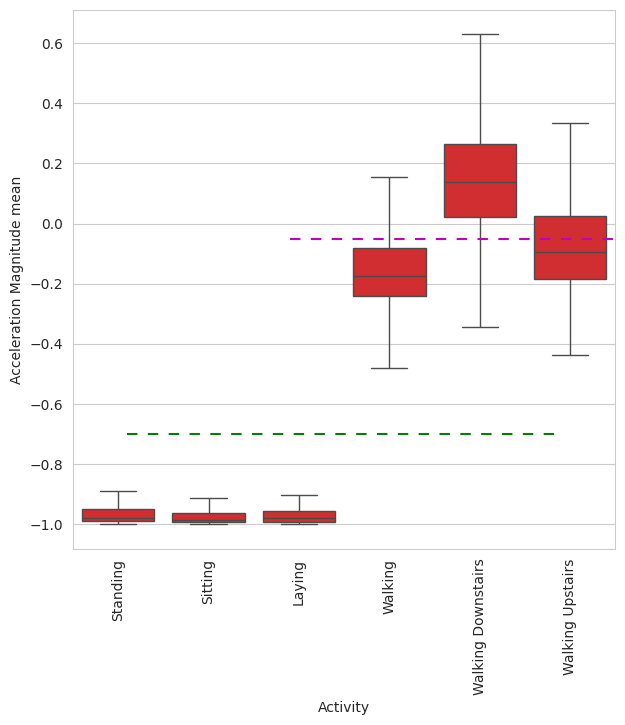

In [7]:
plt.figure(figsize=(7,7))
sns.boxplot(x='Activity', y='201_tBodyAccMag-mean()',data=train, showfliers=False, saturation=1)
plt.ylabel('Acceleration Magnitude mean')
plt.axhline(y=-0.7, xmin=0.1, xmax=0.9,dashes=(5,5), c='g')
plt.axhline(y=-0.05, xmin=0.4, dashes=(5,5), c='m')
plt.xticks(rotation=90)
plt.show()

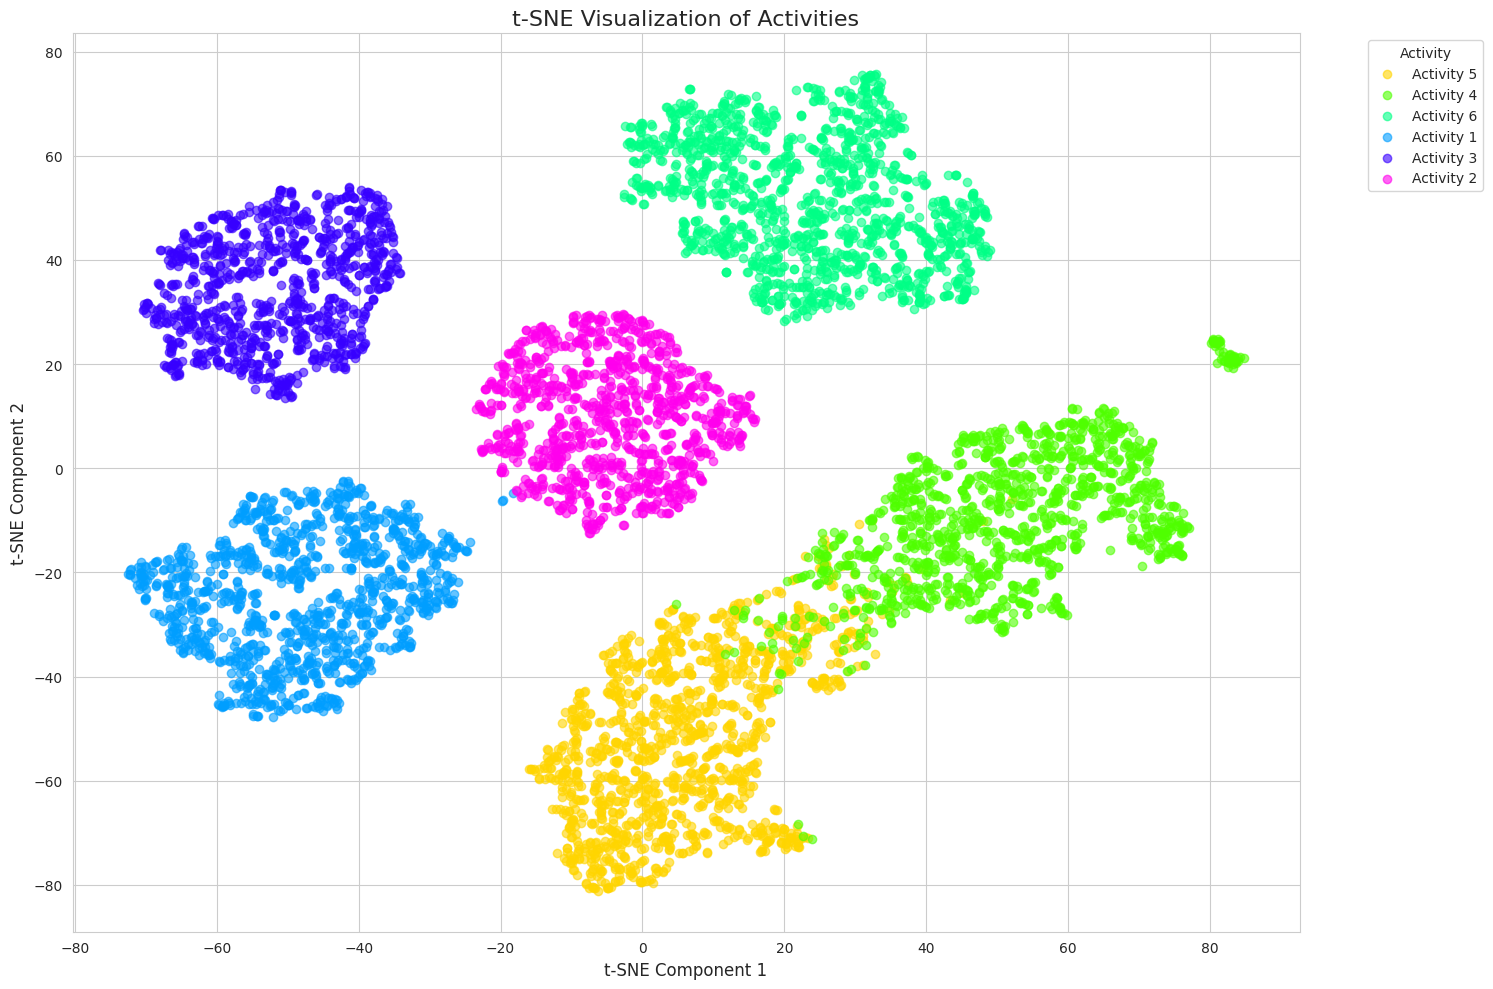

In [8]:
# Prepare data
features = train.drop(['Activity', 'Numerical Label', 'subject'], axis=1)
labels = train['Numerical Label']

# Standardize features
scl = StandardScaler()
features_scaled = scl.fit_transform(features)

# Apply PCA
lda = LDA()
lda_transformed = lda.fit_transform(features_scaled, labels)

# Apply t-SNE
tsne = TSNE(random_state=42)
tsne_transformed = tsne.fit_transform(lda_transformed)

# Create subplots
fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Generate colors
n = len(labels.unique())
colors = sns.color_palette('hsv', n)

# Plot each activity
for i, group in enumerate(labels.unique()):
    mask = labels == group
    ax.scatter(
        tsne_transformed[mask][:, 0],
        tsne_transformed[mask][:, 1],
        color=colors[i],
        alpha=0.6,
        label=f"Activity {group}"
    )

# Add labels, legend, and title
ax.set_title("t-SNE Visualization of Activities", fontsize=16)
ax.set_xlabel("t-SNE Component 1", fontsize=12)
ax.set_ylabel("t-SNE Component 2", fontsize=12)
ax.legend(title="Activity", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


In [9]:
# Check for class distribution in y_train
class_distribution_train = y_train[0].value_counts()
print("Class distribution in y_train:")
print(class_distribution_train)

# Check for class distribution in y_val
class_distribution_val = y_val[0].value_counts()
print("\nClass distribution in y_test:")
print(class_distribution_val)

# Check for class distribution in y_test
class_distribution_test = y_test[0].value_counts()
print("\nClass distribution in y_test:")
print(class_distribution_test)

Class distribution in y_train:
0
6    1407
5    1374
4    1286
1    1226
2    1073
3     986
Name: count, dtype: int64

Class distribution in y_test:
0
5    278
6    258
1    254
4    235
2    225
3    223
Name: count, dtype: int64

Class distribution in y_test:
0
6    279
4    256
5    254
2    246
1    242
3    197
Name: count, dtype: int64


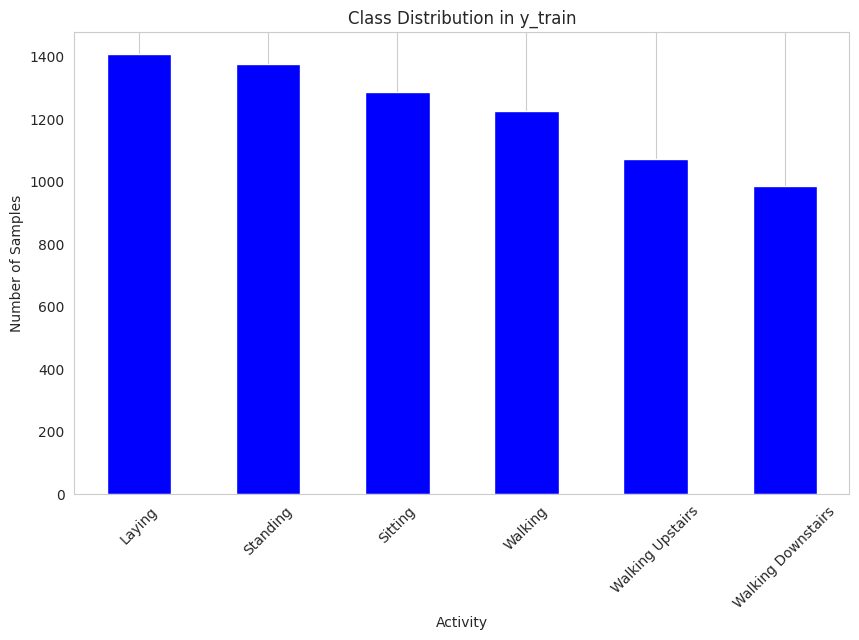

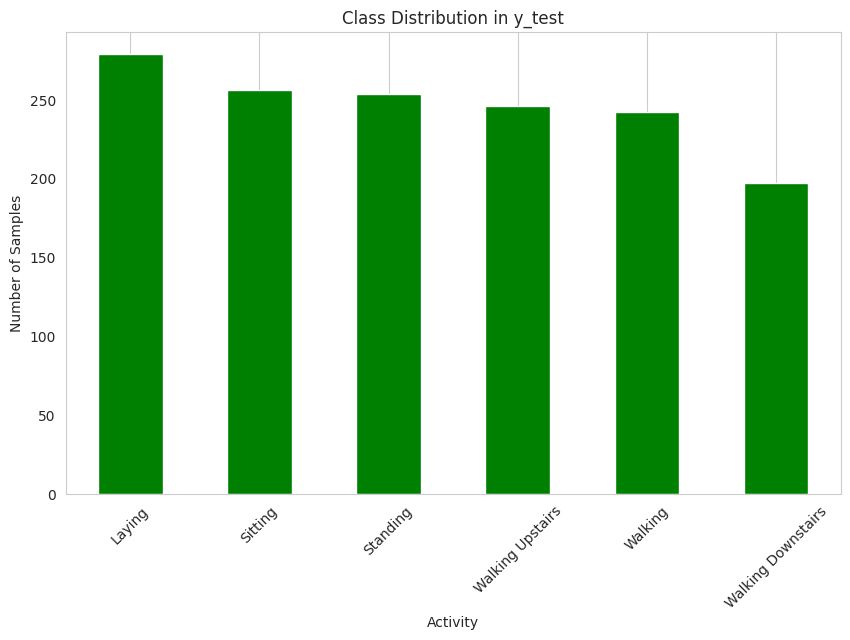

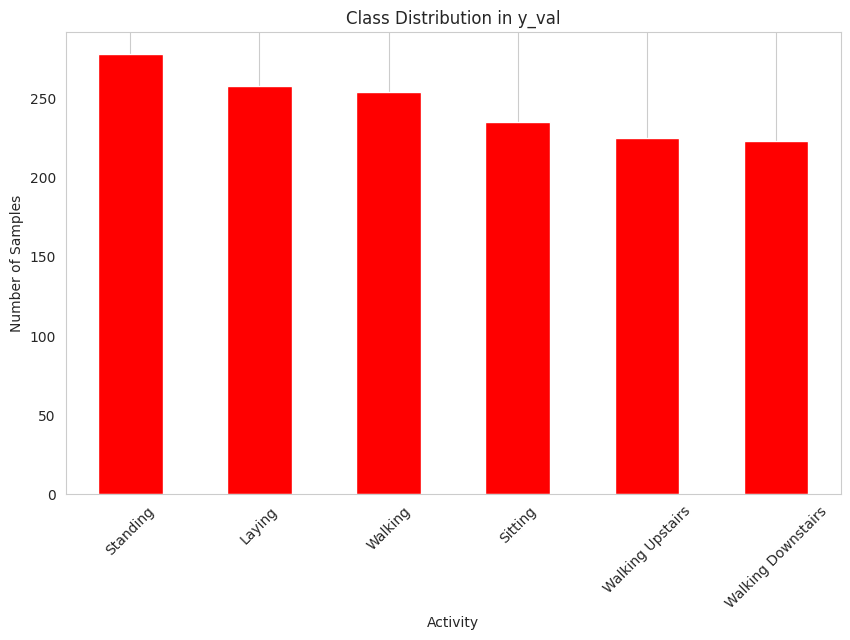

In [10]:
# Bar chart for y_train class distribution
class_distribution_train = y_train_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_train.plot(kind='bar', color='blue')
plt.title('Class Distribution in y_train')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Bar chart for y_train class distribution
class_distribution_test = y_test_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_test.plot(kind='bar', color='green')
plt.title('Class Distribution in y_test')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

# Bar chart for y_val class distribution
class_distribution_val = y_val_labels['Descriptive Label'].value_counts()
plt.figure(figsize=(10, 6))
class_distribution_val.plot(kind='bar', color='red')
plt.title('Class Distribution in y_val')
plt.xlabel('Activity')
plt.ylabel('Number of Samples')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Check and deal with missing values and duplicates

In [11]:
# Check for missing values in X_train
missing_values_X_train = X_train.isnull().sum()
print("Missing values in X_train:\n", missing_values_X_train[missing_values_X_train > 0])

# Check for missing values in X_test
missing_values_X_test = X_test.isnull().sum()
print("\nMissing values in X_test:\n", missing_values_X_test[missing_values_X_test > 0])

# Check for missing values in y_train
missing_values_y_train = y_train.isnull().sum()
print("\nMissing values in y_train:\n", missing_values_y_train[missing_values_y_train > 0])

# Check for missing values in y_test
missing_values_y_test = y_test.isnull().sum()
print("\nMissing values in y_test:\n", missing_values_y_test[missing_values_y_test > 0])

Missing values in X_train:
 Series([], dtype: int64)

Missing values in X_test:
 Series([], dtype: int64)

Missing values in y_train:
 Series([], dtype: int64)

Missing values in y_test:
 Series([], dtype: int64)


In [12]:
print('No of duplicates in X_train: {}'.format(sum(X_train.duplicated())))
print('No of duplicates in X_test : {}'.format(sum(X_test.duplicated())))

No of duplicates in X_train: 0
No of duplicates in X_test : 0


## Identify Correlations Between Features. May not be useful yet.

In [13]:
# Assuming X_train is your training dataset as a DataFrame
correlation_matrix = X_train.corr()

# Set a threshold for correlation
threshold = 0.75

# Get the absolute correlation matrix
abs_correlation = correlation_matrix.abs()

# Create a DataFrame to hold the pairs of correlated features
highly_correlated_pairs = []

# Iterate through the correlation matrix
for i in range(len(abs_correlation.columns)):
    for j in range(i):
        # Check if the correlation is above the threshold and features are different
        if abs_correlation.iloc[i, j] > threshold and abs_correlation.columns[i] != abs_correlation.columns[j]:
            highly_correlated_pairs.append((abs_correlation.columns[i], abs_correlation.columns[j], abs_correlation.iloc[i, j]))

# Create a DataFrame for better visualization
highly_correlated_df = pd.DataFrame(highly_correlated_pairs, columns=['Feature 1', 'Feature 2', 'Correlation'])

# Print only the pairs of highly correlated features where Feature 1 is different from Feature 2
print("Highly correlated features:")
print(highly_correlated_df)

Highly correlated features:
                      Feature 1                  Feature 2  Correlation
0            5_tBodyAcc-std()-Y         4_tBodyAcc-std()-X     0.927461
1            6_tBodyAcc-std()-Z         4_tBodyAcc-std()-X     0.851668
2            6_tBodyAcc-std()-Z         5_tBodyAcc-std()-Y     0.895510
3            7_tBodyAcc-mad()-X         4_tBodyAcc-std()-X     0.998632
4            7_tBodyAcc-mad()-X         5_tBodyAcc-std()-Y     0.922803
...                         ...                        ...          ...
29480  560_angle(Y,gravityMean)  58_tGravityAcc-energy()-Y     0.880564
29481  560_angle(Y,gravityMean)   559_angle(X,gravityMean)     0.783848
29482  561_angle(Z,gravityMean)    43_tGravityAcc-mean()-Z     0.995070
29483  561_angle(Z,gravityMean)     52_tGravityAcc-max()-Z     0.992869
29484  561_angle(Z,gravityMean)     55_tGravityAcc-min()-Z     0.990991

[29485 rows x 3 columns]


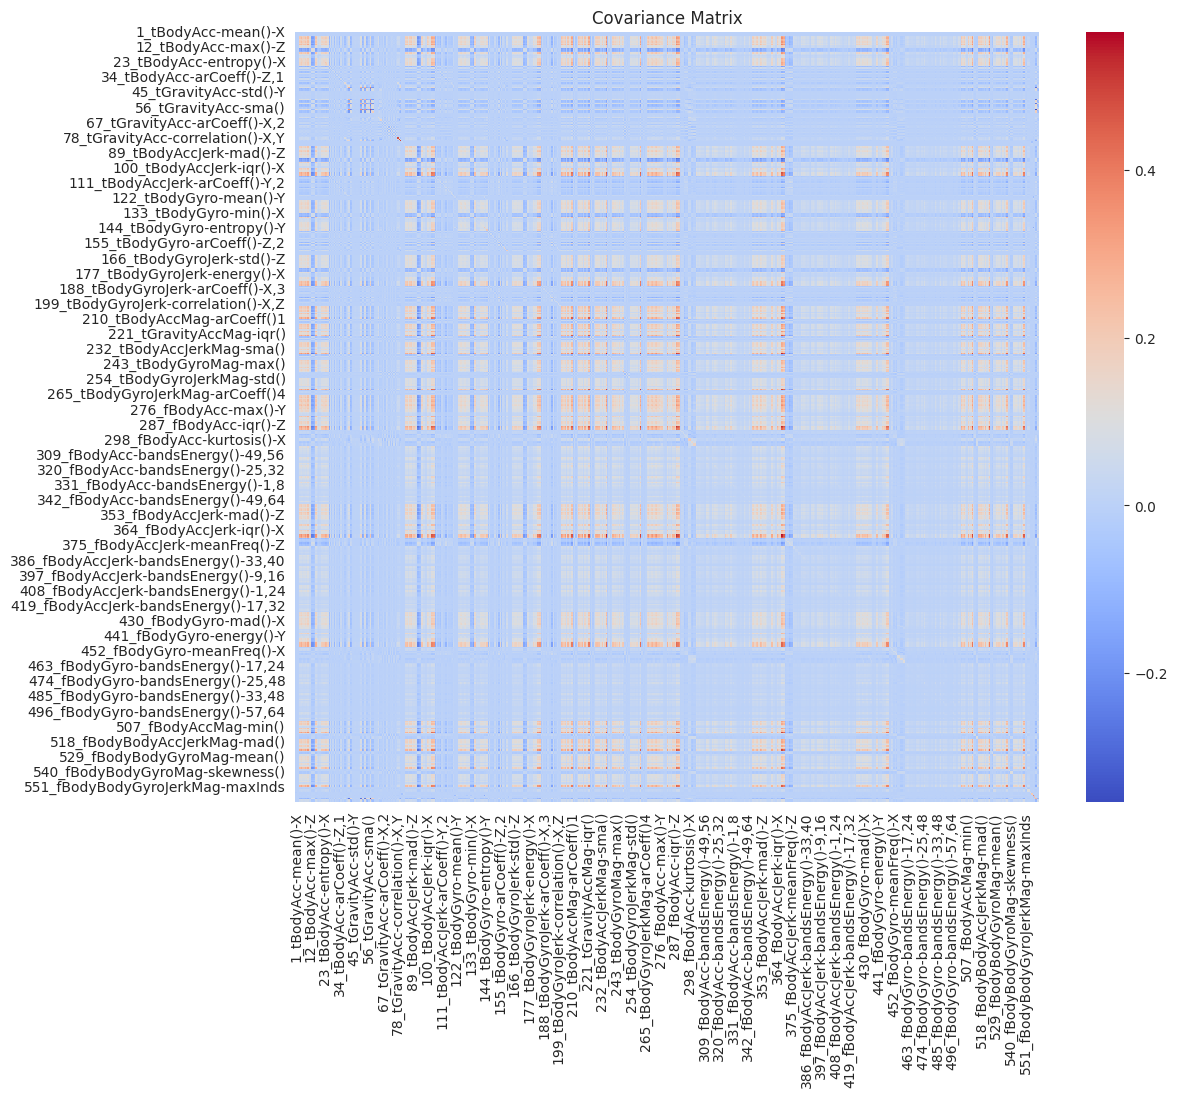

In [14]:
# Step 1: Compute the covariance matrix
cov_matrix = np.cov(features.T)  # Transpose ensures features are treated as variables

# Step 2: Create a DataFrame for better readability
cov_df = pd.DataFrame(cov_matrix, index=features.columns, columns=features.columns)

# Step 3: Plot the covariance matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cov_df, annot=False, cmap='coolwarm', cbar=True)
plt.title("Covariance Matrix")
plt.show()

## Standardize Features

In [15]:
scaler = StandardScaler()

# Fit the scaler on the training data
scaler.fit(X_train)

# Transform the training, test, and validation data using the fitted scaler
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)
X_val_scaled = scaler.transform(X_val)

## Identify number of components needed for PCA to maintain 95% of Variance

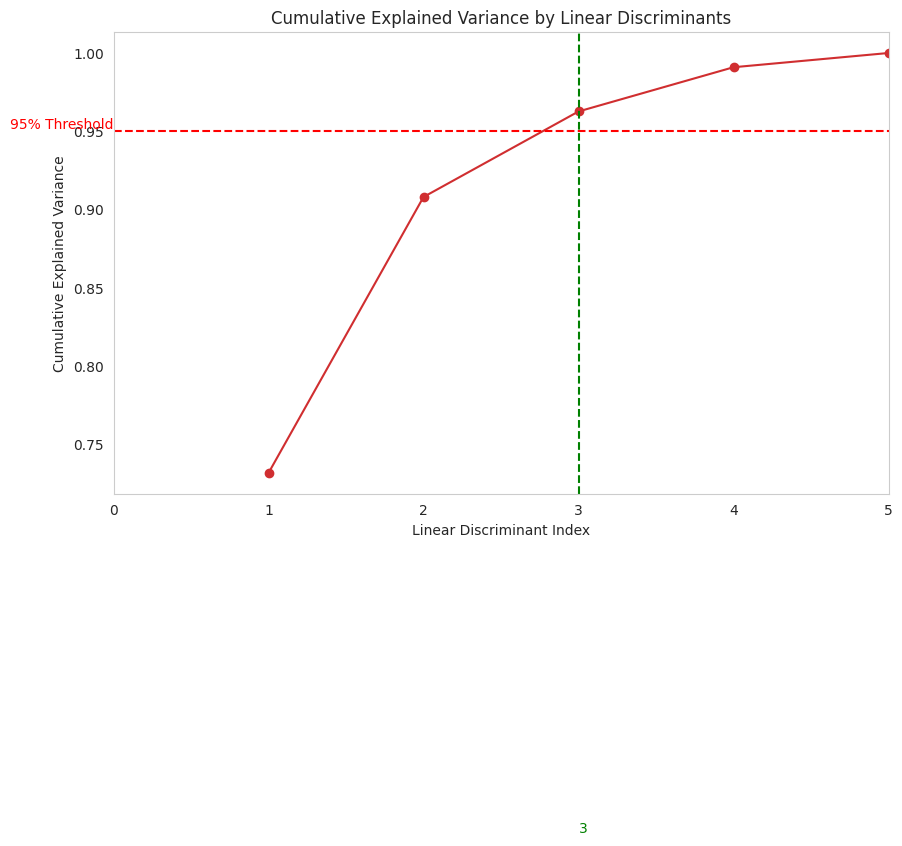

In [16]:
# Apply PCA
lda = LDA()
X_train_lda = lda.fit(X_train_scaled, np.ravel(y_train)).transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)
X_val_lda = lda.transform(X_val_scaled)

cumulative_explained_variance = np.cumsum(lda.explained_variance_ratio_)

# Create a plot for cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by Linear Discriminants')
plt.xlabel('Linear Discriminant Index')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.xlim(1, len(cumulative_explained_variance)) # Set x-axis limits
plt.xticks(np.arange(0, len(cumulative_explained_variance) + 1, step=1)) # Set x-ticks at intervals
plt.axhline(y=0.95, color='r', linestyle='--') # Optional line at 95% explained variance
plt.text(0, 0.95, '95% Threshold', color='red', verticalalignment='bottom', horizontalalignment='right')

# Find the index for the first linear discriminant that exceeds 95% cumulative explained variance
index_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1 # +1 to convert to 1-based index

# Add a vertical line at the 95% threshold discriminant
plt.axvline(x=index_95, color='g', linestyle='--')
plt.text(index_95, 0.5, f'{index_95}', color='green', verticalalignment='bottom', horizontalalignment='left')
plt.show() 


In [17]:
# Apply PCA
lda = LDA()
X_train_lda = lda.fit(X_train_scaled, np.ravel(y_train)).transform(X_train_scaled)
X_test_lda = lda.transform(X_test_scaled)
X_val_lda = lda.transform(X_val_scaled)

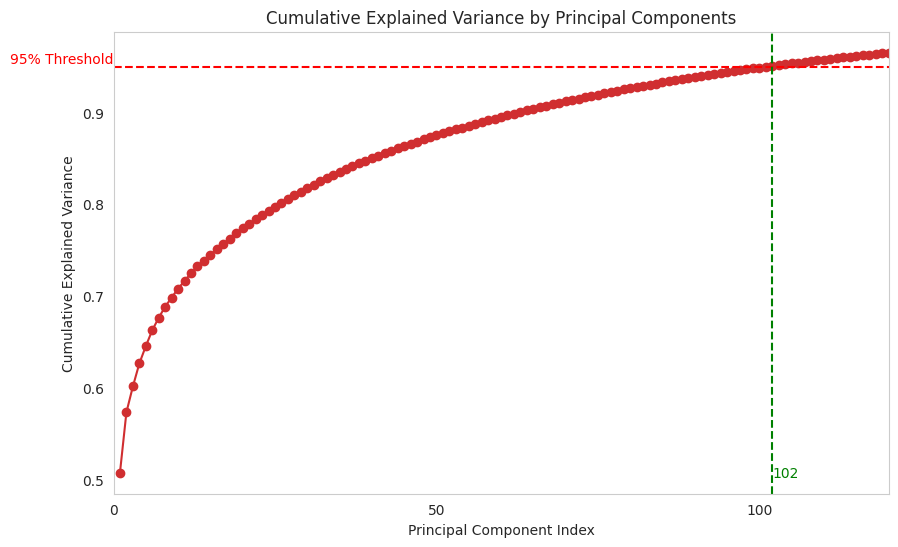

In [18]:
# Fit PCA on your dataset
pca = PCA(n_components=120)
X_train_pca = pca.fit_transform(X_train_scaled)  # Use fit_transform to get the transformed data

# Calculate the cumulative explained variance
cumulative_explained_variance = np.cumsum(pca.explained_variance_ratio_)

# Create a plot for cumulative explained variance
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, marker='o', linestyle='-')
plt.title('Cumulative Explained Variance by Principal Components')
plt.xlabel('Principal Component Index')
plt.ylabel('Cumulative Explained Variance')
plt.grid()
plt.xlim(1, len(cumulative_explained_variance)) # Set x-axis limits
plt.xticks(np.arange(0, len(cumulative_explained_variance) + 1, step=50)) # Set x-ticks at intervals
plt.axhline(y=0.95, color='r', linestyle='--') # Optional line at 95% explained variance

# Find the index for the first principal component that exceeds 95% cumulative explained variance
index_95 = np.argmax(cumulative_explained_variance >= 0.95) + 1 # +1 to convert to 1-based index

# Add a vertical line at the 95% threshold component
plt.axvline(x=index_95, color='g', linestyle='--')
plt.text(index_95, 0.5, f'{index_95}', color='green', verticalalignment='bottom', horizontalalignment='left')
plt.text(0, 0.95, '95% Threshold', color='red', verticalalignment='bottom', horizontalalignment='right')
plt.show()

## Transform X_train and X_test using PCA

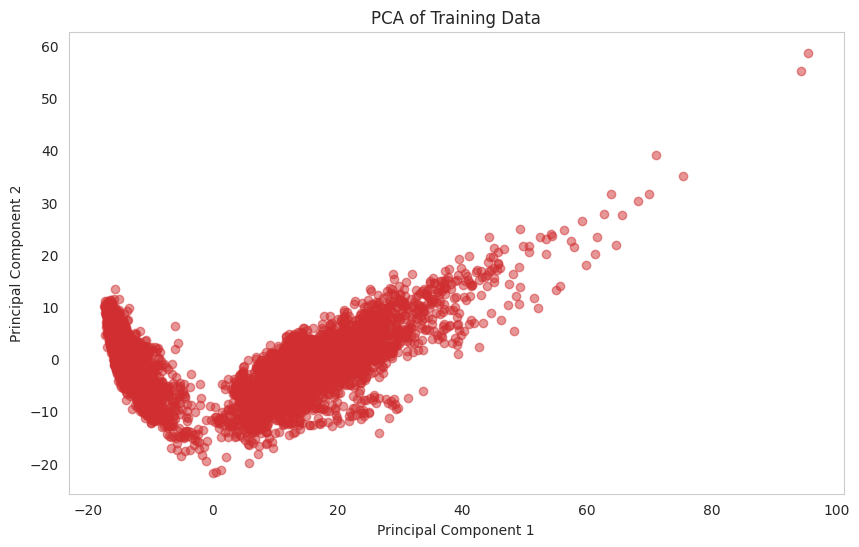

In [19]:
# Apply dimensionality reduction using PCA with optimnal n_components
pca = PCA(n_components=102)
X_train_pca = pca.fit_transform(X_train_scaled) # Fit to train data to prevent leakage and then transform
X_test_pca = pca.transform(X_test_scaled) # transform test and val data
X_val_pca = pca.transform(X_val_scaled)


# Scatter Plot of the First Two Principal Components
plt.figure(figsize=(10, 6))
plt.scatter(X_train_pca[:, 0], X_train_pca[:, 1], alpha=0.5)
plt.title('PCA of Training Data')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()


In [20]:
'''# Select only two classes (e.g., 1 and 2)
mask = np.isin(y_train, [1, 2])
print(X_train_scaled.shape)

# Apply the mask to select rows corresponding to these classes
X_subset = X_train_scaled[mask]  # Apply mask to rows (axis 0), all columns (axis 1)
y_subset = y_train[mask]

# Apply PCA to reduce the dimensionality to 2 for visualization
pca = PCA(n_components=2)
x_pca = pca.fit_transform(X_subset)

# Apply LDA to reduce the dimensionality to 1 (only possible since there are two classes)
lda = LDA(n_components=1)  # For two classes, we can have at most 1 LD
x_lda = lda.fit_transform(X_subset, y_subset)

# Create the figure
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# LDA Plot (1D)
scatter_lda = axes[1].scatter(x_lda, np.zeros_like(x_lda), c=y_subset, cmap='coolwarm')
axes[1].set_title("LDA (1D)")
axes[1].set_xlabel("LD1")
axes[1].set_yticks([])  # No Y-axis as it is 1D

# PCA Plot (2D)
scatter_pca = axes[0].scatter(x_pca[:, 0], x_pca[:, 1], c=y_subset, cmap='coolwarm')
axes[0].set_title("PCA (2D)")
axes[0].set_xlabel("PC1")
axes[0].set_ylabel("PC2")

# Display the plots
plt.show()
'''

'# Select only two classes (e.g., 1 and 2)\nmask = np.isin(y_train, [1, 2])\nprint(X_train_scaled.shape)\n\n# Apply the mask to select rows corresponding to these classes\nX_subset = X_train_scaled[mask]  # Apply mask to rows (axis 0), all columns (axis 1)\ny_subset = y_train[mask]\n\n# Apply PCA to reduce the dimensionality to 2 for visualization\npca = PCA(n_components=2)\nx_pca = pca.fit_transform(X_subset)\n\n# Apply LDA to reduce the dimensionality to 1 (only possible since there are two classes)\nlda = LDA(n_components=1)  # For two classes, we can have at most 1 LD\nx_lda = lda.fit_transform(X_subset, y_subset)\n\n# Create the figure\nfig, axes = plt.subplots(1, 2, figsize=(12, 6))\n\n# LDA Plot (1D)\nscatter_lda = axes[1].scatter(x_lda, np.zeros_like(x_lda), c=y_subset, cmap=\'coolwarm\')\naxes[1].set_title("LDA (1D)")\naxes[1].set_xlabel("LD1")\naxes[1].set_yticks([])  # No Y-axis as it is 1D\n\n# PCA Plot (2D)\nscatter_pca = axes[0].scatter(x_pca[:, 0], x_pca[:, 1], c=y_subse

## Detect and Deal with Anomolies. Should do this before PCA if we are goint to do it.

In [21]:
'''# Define the threshold for anomaly detection
threshold = 3

# Initialize a variable to keep track of the maximum number of anomalies
max_anomalies = 0
max_anomalies_column = None

# Iterate through each column in the training dataset
for col in X_train.columns:
    # Calculate Z-scores for the column
    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()

    # Identify anomalies in the column
    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)

    # Get indices of anomalies for the current column
    anomaly_indices_train = np.where(anomalies_train)[0]

    # Count the number of anomalies detected for the current column
    num_anomalies = len(anomaly_indices_train)
    
    # Print number of anomalies detected for the current column
    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')

    # Check if the current number of anomalies is greater than the max found so far
    if num_anomalies > max_anomalies:
        max_anomalies = num_anomalies
        max_anomalies_column = col

# After iterating through all columns, print the maximum number of anomalies found
print(f'Maximum number of anomalies detected in a single column: {max_anomalies} (Column {max_anomalies_column})')'''

"# Define the threshold for anomaly detection\nthreshold = 3\n\n# Initialize a variable to keep track of the maximum number of anomalies\nmax_anomalies = 0\nmax_anomalies_column = None\n\n# Iterate through each column in the training dataset\nfor col in X_train.columns:\n    # Calculate Z-scores for the column\n    z_scores_train = (X_train[col] - X_train[col].mean()) / X_train[col].std()\n\n    # Identify anomalies in the column\n    anomalies_train = (z_scores_train > threshold) | (z_scores_train < -threshold)\n\n    # Get indices of anomalies for the current column\n    anomaly_indices_train = np.where(anomalies_train)[0]\n\n    # Count the number of anomalies detected for the current column\n    num_anomalies = len(anomaly_indices_train)\n    \n    # Print number of anomalies detected for the current column\n    print(f'Column {col}: Number of anomalies in training set: {num_anomalies}')\n\n    # Check if the current number of anomalies is greater than the max found so far\n    if 

## Create, train and evaluate Random Forrest Model

Random Forest model size: 0.000053 MB
Average Inference Time per Sample: 0.000012 seconds
Accuracy: 0.8779
Precision: 0.8842
Recall: 0.8779
F1 Score: 0.8769
Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.96      0.89       242
           1       0.91      0.90      0.90       246
           2       0.92      0.74      0.82       197
           3       0.86      0.75      0.80       256
           4       0.79      0.93      0.85       254
           5       1.00      0.96      0.98       279

    accuracy                           0.88      1474
   macro avg       0.88      0.87      0.87      1474
weighted avg       0.88      0.88      0.88      1474



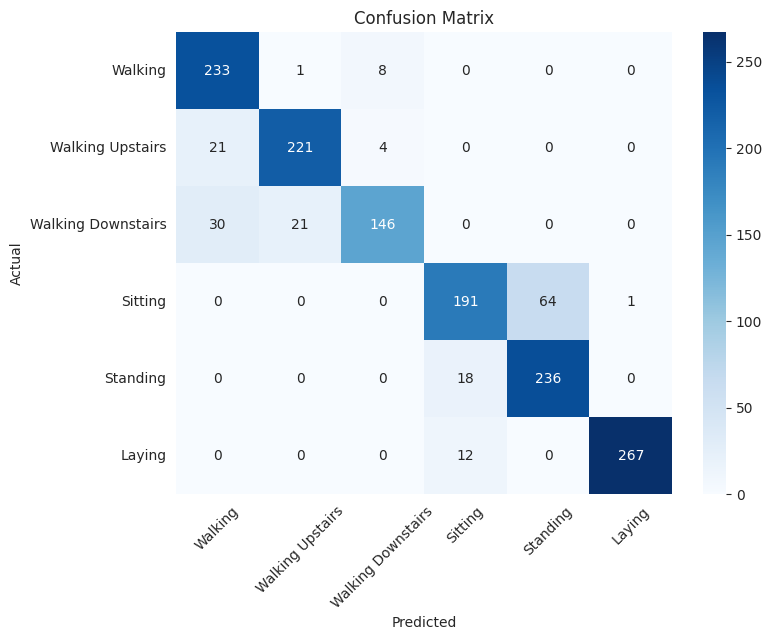

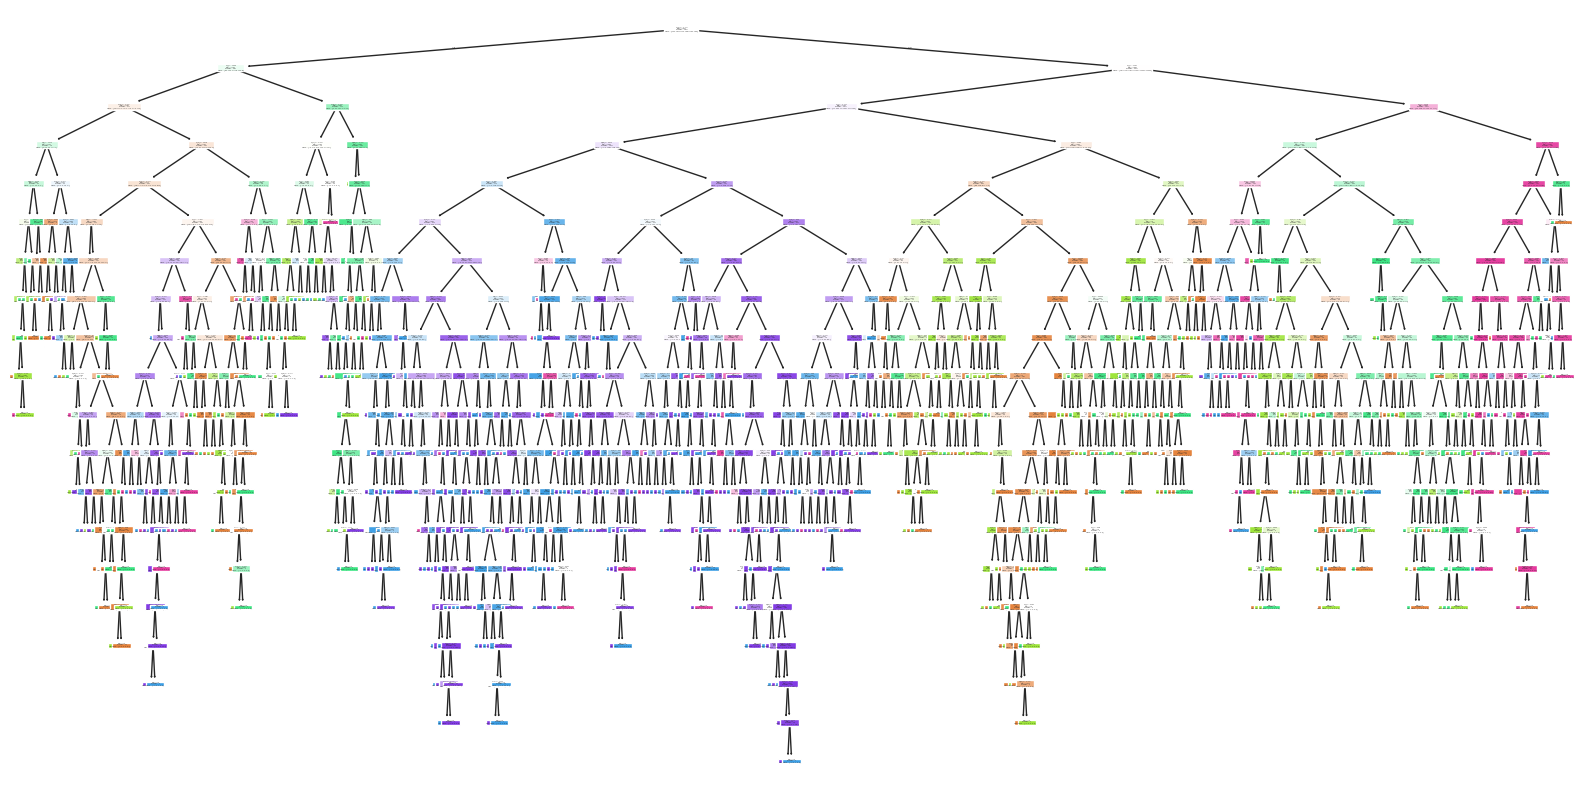

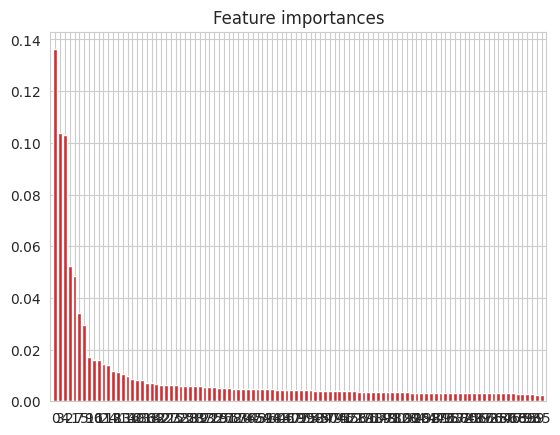

In [ ]:
# Convert labels to one-hot encoding for classification problem
y_train_categorical = to_categorical(y_train - 1, num_classes=6)  # y_train has values 1 to 6
y_val_categorical = to_categorical(y_val - 1, num_classes=6)
y_test_categorical = to_categorical(y_test - 1)

# Convert labels to class indices if they're one-hot encoded
y_train_classes = np.argmax(y_train_categorical, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Fit the Random Forest model
rf_model_pca = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf_model_pca.fit(X_train_pca, y_train_classes)

# Record the start time for inference
start_time = time.time()

# Make predictions with the Random Forest model
y_pred_rf = rf_model_pca.predict(X_test_pca)  # This will return class labels directly

# Record the end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_pca)

model_size = sys.getsizeof(rf_model_pca)
print(f"Random Forest model size: {model_size / (1024 ** 2):.6f} MB")
print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_classes, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test_classes, y_pred_rf, average='weighted')  # Weighted average
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_classes, y_pred_rf, average='weighted')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test_classes, y_pred_rf, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_rf))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_rf)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Plot one of the trees in the forest (using feature names and class names if available)
plt.figure(figsize=(20, 10))
plot_tree(rf_model_pca.estimators_[0], filled=True)
plt.show()

importances = rf_model_pca.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train_pca.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_pca.shape[1]), indices)
plt.xlim([-1, X_train_pca.shape[1]])
plt.show()


Random Forest model size: 0.000053 MB
Average Inference Time per Sample: 0.000015 seconds
Accuracy: 0.9600
Precision: 0.9618
Recall: 0.9600
F1 Score: 0.9599
Classification Report:
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       242
           1       0.97      0.97      0.97       246
           2       1.00      0.97      0.98       197
           3       0.97      0.86      0.91       256
           4       0.88      0.97      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



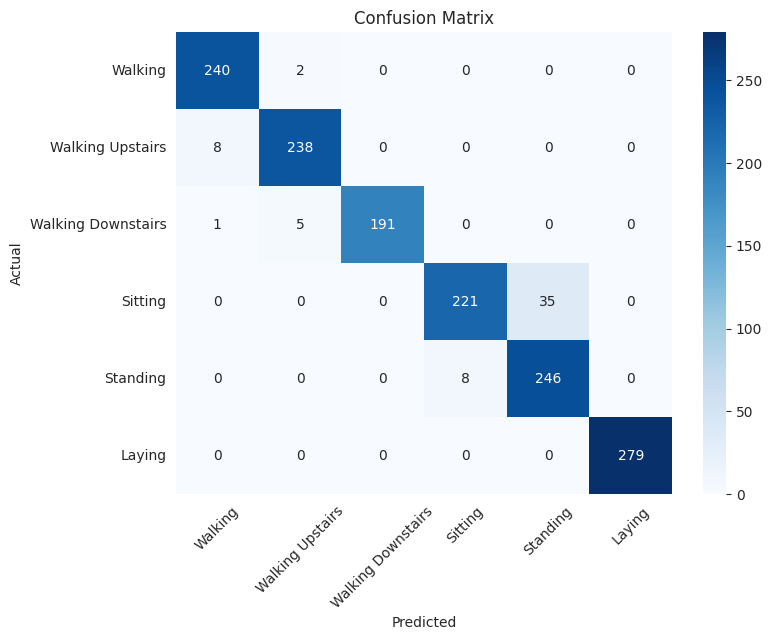

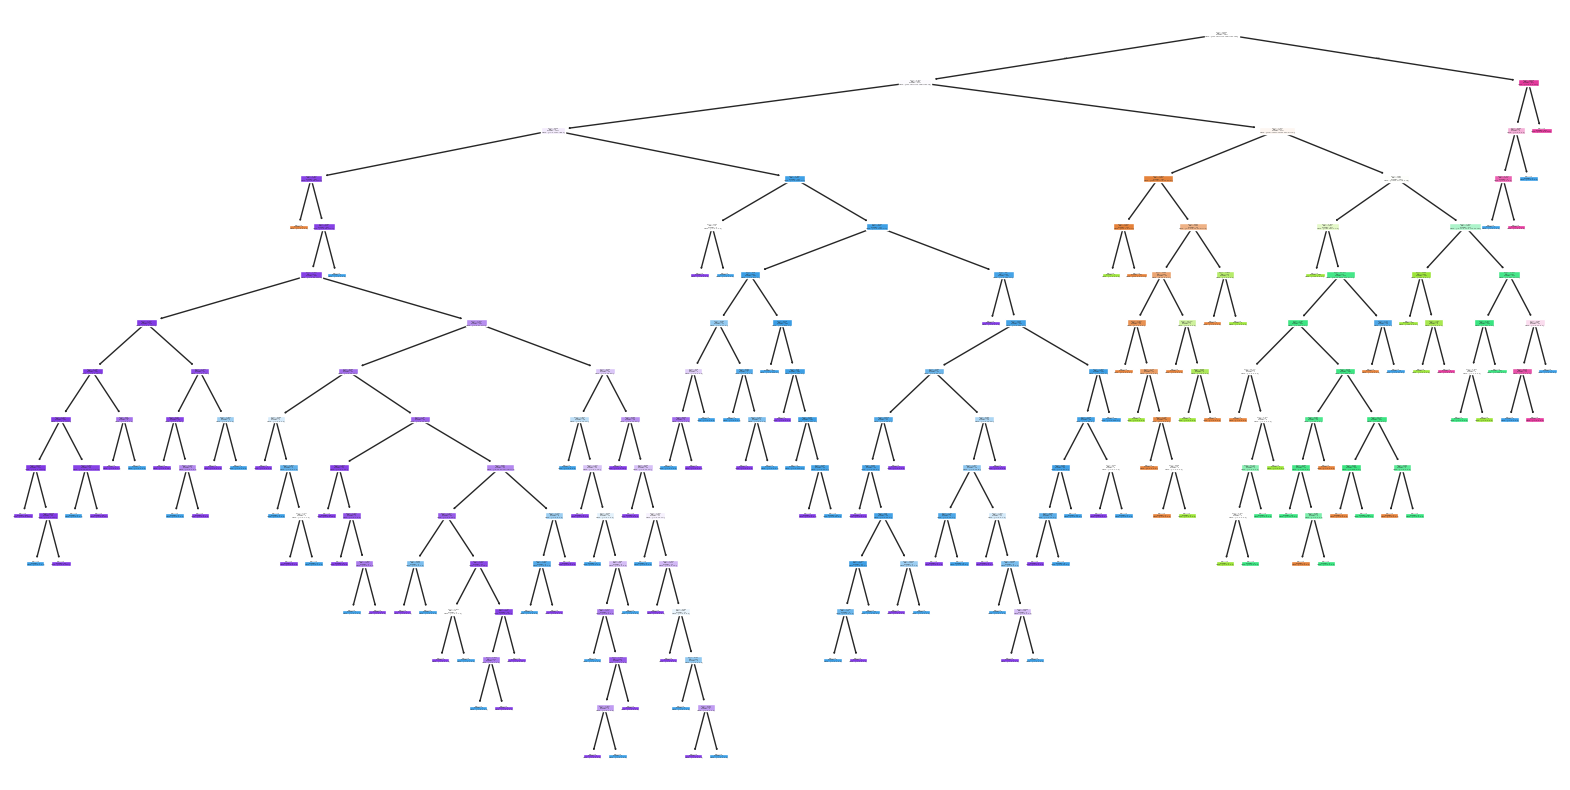

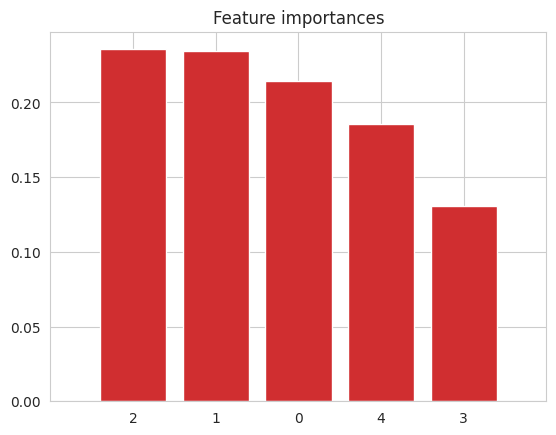

In [ ]:
# Convert labels to class indices if they're one-hot encoded
y_train_classes = np.argmax(y_train_categorical, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Fit the Random Forest model
rf_model_lda = RandomForestClassifier(n_estimators=50, max_depth=20, random_state=42)
rf_model_lda.fit(X_train_lda, y_train_classes)

# Record the start time for inference
start_time = time.time()

# Make predictions with the Random Forest model
y_pred_rf = rf_model_lda.predict(X_test_lda)  # This will return class labels directly

# Record the end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

model_size = sys.getsizeof(rf_model_lda)
print(f"Random Forest model size: {model_size / (1024 ** 2):.6f} MB")
print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_classes, y_pred_rf)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test_classes, y_pred_rf, average='weighted')  # Weighted average
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_classes, y_pred_rf, average='weighted')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test_classes, y_pred_rf, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_rf))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_rf)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Plot one of the trees in the forest (using feature names and class names if available)
plt.figure(figsize=(20, 10))
plot_tree(rf_model_lda.estimators_[0], filled=True)
plt.show()

importances = rf_model_lda.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(20, 10))
plt.title("Feature importances")
plt.bar(range(X_train_lda.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train_lda.shape[1]), indices)
plt.xlim([-1, X_train_lda.shape[1]])
plt.show()



## Evaluate Random Forrest model for over fitting

In [30]:
# Print training and test accuracy to monitor overfitting
train_accuracy = accuracy_score(y_train_classes, rf_model_pca.predict(X_train_pca))
test_accuracy = accuracy_score(y_test_classes, rf_model_pca.predict(X_test_pca))

print(f'PCA Training Accuracy: {train_accuracy:.2f}')
print(f'PCA Test Accuracy: {test_accuracy:.2f}')

# Perform cross-validation to confirm results
cv_scores = cross_val_score(rf_model_pca, X_train_pca, y_train_categorical, cv=10)
print(f'PCA Mean Cross-Validation Score: {cv_scores.mean():.2f}\n')

# Print training and test accuracy to monitor overfitting
train_accuracy = accuracy_score(y_train_classes, rf_model_lda.predict(X_train_lda))
test_accuracy = accuracy_score(y_test_classes, rf_model_lda.predict(X_test_lda))

print(f'LDA Training Accuracy: {train_accuracy:.2f}')
print(f'LDA Test Accuracy: {test_accuracy:.2f}')

# Perform cross-validation to confirm results
cv_scores = cross_val_score(rf_model_lda, X_train_lda, y_train_categorical, cv=10)
print(f'LDA Mean Cross-Validation Score: {cv_scores.mean():.2f}')

PCA Training Accuracy: 1.00
PCA Test Accuracy: 0.88
PCA Mean Cross-Validation Score: 0.72

LDA Training Accuracy: 1.00
LDA Test Accuracy: 0.96
LDA Mean Cross-Validation Score: 0.98


## Build, Train and Evaluate Neural Network



Epoch 1/20


230/230 [==============================] - 3s 8ms/step - loss: 1.5880 - accuracy: 0.4803 - val_loss: 0.6843 - val_accuracy: 0.7434
Epoch 2/20
230/230 [==============================] - 1s 3ms/step - loss: 0.3784 - accuracy: 0.8923 - val_loss: 0.3029 - val_accuracy: 0.9063
Epoch 3/20
230/230 [==============================] - 2s 8ms/step - loss: 0.1852 - accuracy: 0.9461 - val_loss: 0.2236 - val_accuracy: 0.9240
Epoch 4/20
230/230 [==============================] - 2s 7ms/step - loss: 0.1315 - accuracy: 0.9603 - val_loss: 0.1926 - val_accuracy: 0.9274
Epoch 5/20
230/230 [==============================] - 1s 6ms/step - loss: 0.1066 - accuracy: 0.9655 - val_loss: 0.1798 - val_accuracy: 0.9321
Epoch 6/20
230/230 [==============================] - 1s 5ms/step - loss: 0.0917 - accuracy: 0.9710 - val_loss: 0.1789 - val_accuracy: 0.9341
Epoch 7/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0829 - accuracy: 0.9728 - val_loss: 0.1741 - val_accuracy: 0.9348
Ep

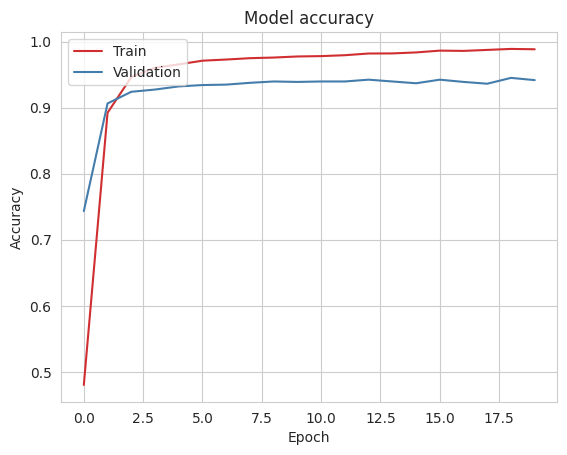

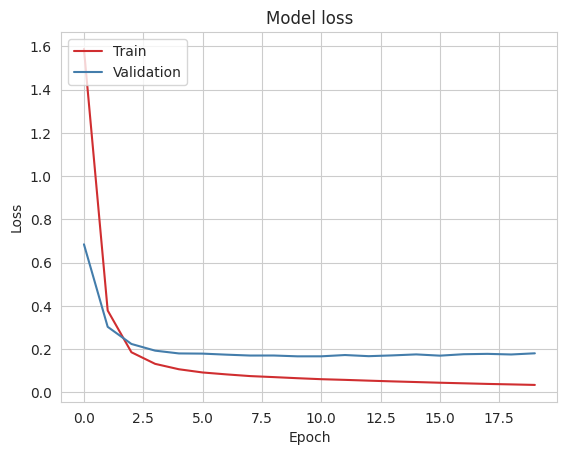

In [31]:
# Define the input shape (102 principal components)
input_shape_pca = (102,)

# Create a Sequential model
model_pca = Sequential()

# Add layers to the model, increasing complexity leads to overfitting very quickly
model_pca.add(Input(shape=input_shape_pca))  # This sets the input shape
model_pca.add(Dense(16, activation='relu'))   # One hidden layer
model_pca.add(Dense(6, activation='softmax'))  # Output layer

# Compile the model
model_pca.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using one-hot encoded labels
history_pca = model_pca.fit(X_train_pca, y_train_categorical, validation_data=(X_val_pca, y_val_categorical), epochs=20, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history_pca.history['accuracy'])
plt.plot(history_pca.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_pca.history['loss'])
plt.plot(history_pca.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

47/47 [==============================] - 0s 3ms/step - loss: 0.2126 - accuracy: 0.9301
Test Loss: 0.2126
Test Accuracy: 0.9301
47/47 [==============================] - 0s 3ms/step


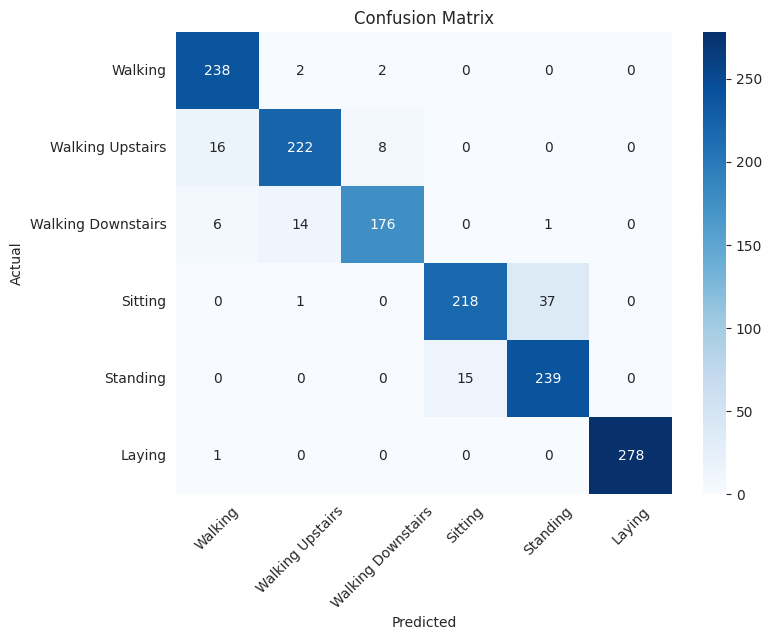

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000347 seconds
Precision: 0.9317
Recall: 0.9301
F1 Score: 0.9299
              precision    recall  f1-score   support

           0       0.91      0.98      0.95       242
           1       0.93      0.90      0.92       246
           2       0.95      0.89      0.92       197
           3       0.94      0.85      0.89       256
           4       0.86      0.94      0.90       254
           5       1.00      1.00      1.00       279

    accuracy                           0.93      1474
   macro avg       0.93      0.93      0.93      1474
weighted avg       0.93      0.93      0.93      1474



In [32]:
# Evaluate the model on the test set
loss, accuracy = model_pca.evaluate(X_test_pca, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model_pca.predict(X_test_pca)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_pca)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model_size = sys.getsizeof(model_pca)
print(f"CNN model size: {model_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

Epoch 1/20
230/230 [==============================] - 2s 6ms/step - loss: 1.8115 - accuracy: 0.6462 - val_loss: 0.1406 - val_accuracy: 0.9647
Epoch 2/20
230/230 [==============================] - 1s 6ms/step - loss: 0.0513 - accuracy: 0.9854 - val_loss: 0.1272 - val_accuracy: 0.9640
Epoch 3/20
230/230 [==============================] - 1s 6ms/step - loss: 0.0424 - accuracy: 0.9861 - val_loss: 0.1183 - val_accuracy: 0.9661
Epoch 4/20
230/230 [==============================] - 1s 6ms/step - loss: 0.0399 - accuracy: 0.9863 - val_loss: 0.1175 - val_accuracy: 0.9661
Epoch 5/20
230/230 [==============================] - 1s 6ms/step - loss: 0.0384 - accuracy: 0.9859 - val_loss: 0.1139 - val_accuracy: 0.9654
Epoch 6/20
230/230 [==============================] - 2s 7ms/step - loss: 0.0373 - accuracy: 0.9860 - val_loss: 0.1154 - val_accuracy: 0.9654
Epoch 7/20
230/230 [==============================] - 2s 8ms/step - loss: 0.0367 - accuracy: 0.9861 - val_loss: 0.1087 - val_accuracy: 0.9667
Epoch 

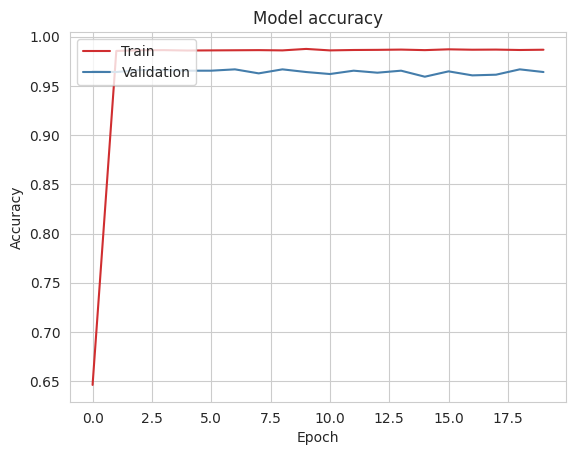

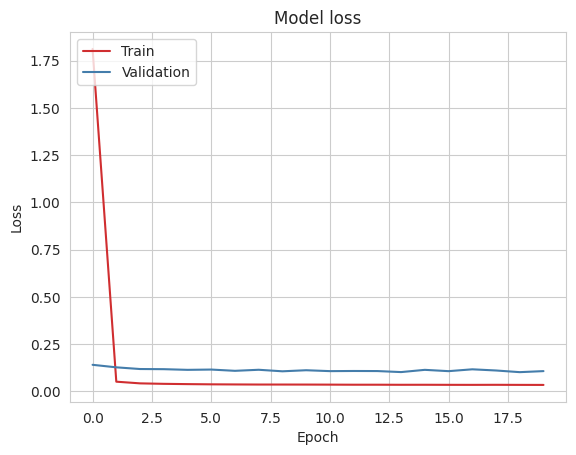

In [33]:
# Define the input shape (5 LDA components)
input_shape_lda = (5,)

# Create a Sequential model
model_lda = Sequential()

# Add layers to the model, increasing complexity leads to overfitting very quickly
model_lda.add(Input(shape=input_shape_lda))  # This sets the input shape
model_lda.add(Dense(16, activation='relu'))   # One hidden layer
model_lda.add(Dense(6, activation='softmax'))  # Output layer

optimizer = Adam(clipnorm=1.0, learning_rate=1e-3)

# Compile the model
model_lda.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using one-hot encoded labels
history_lda = model_lda.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical), epochs=20, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history_lda.history['accuracy'])
plt.plot(history_lda.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history_lda.history['loss'])
plt.plot(history_lda.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

47/47 [==============================] - 0s 3ms/step - loss: 0.1383 - accuracy: 0.9613
Test Loss: 0.1383
Test Accuracy: 0.9613
47/47 [==============================] - 0s 2ms/step


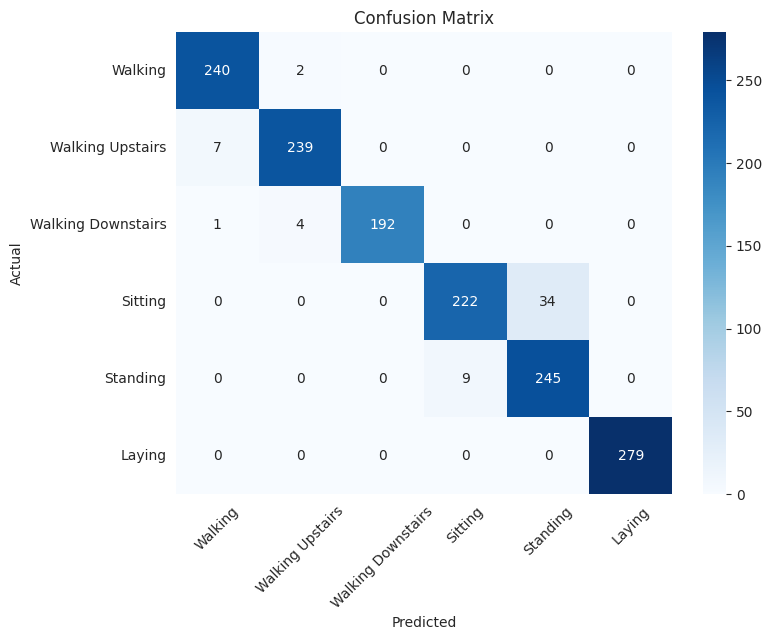

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000242 seconds
Precision: 0.9629
Recall: 0.9613
F1 Score: 0.9613
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       242
           1       0.98      0.97      0.97       246
           2       1.00      0.97      0.99       197
           3       0.96      0.87      0.91       256
           4       0.88      0.96      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



In [34]:
# Evaluate the model on the test set
loss, accuracy = model_lda.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model_lda.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model_size = sys.getsizeof(model_lda)
print(f"CNN model size: {model_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

## Build, Train and Evaluate SVM Model

Random Forest model size: 0.000053 MB
Average Inference Time per Sample: 0.000110 seconds
Accuracy: 0.9627
Precision: 0.9636
Recall: 0.9627
F1 Score: 0.9627
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98       242
           1       0.97      0.98      0.97       246
           2       1.00      0.97      0.98       197
           3       0.95      0.88      0.92       256
           4       0.89      0.96      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



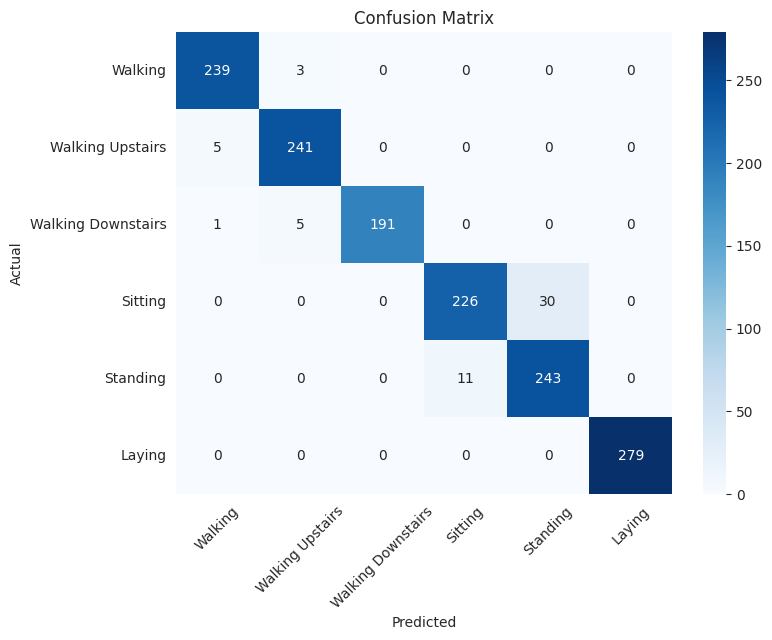

In [35]:
# Convert labels to one-hot encoding for classification problem
y_train_categorical = to_categorical(y_train - 1, num_classes=6)  # y_train has values 1 to 6
y_val_categorical = to_categorical(y_val - 1, num_classes=6)
y_test_categorical = to_categorical(y_test - 1)

# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train_categorical, axis=1)
y_val_classes = np.argmax(y_val_categorical, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Initialize the SVM model
svm_lda = svm.SVC(kernel='rbf', C=1, gamma='scale')

# Fit the SVM model with the correct format for y
svm_lda.fit(X_train_lda, y_train_classes)

# Record the start time for inference
start_time = time.time()

# Make predictions
y_pred_svm = svm_lda.predict(X_test_lda)

# Record the end time for inference
end_time = time.time()

# Calculate total time taken for inference
total_inference_time = end_time - start_time

# Calculate average time per sample
average_inference_time = total_inference_time / len(X_test_lda)

model_size = sys.getsizeof(svm_lda)
print(f"Random Forest model size: {model_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_classes, y_pred_svm)
print(f"Accuracy: {accuracy:.4f}")

precision = precision_score(y_test_classes, y_pred_svm, average='weighted')
print(f"Precision: {precision:.4f}")

recall = recall_score(y_test_classes, y_pred_svm, average='weighted')
print(f"Recall: {recall:.4f}")

f1 = f1_score(y_test_classes, y_pred_svm, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_svm))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_svm)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()


Random Forest model size: 0.000053 MB
Average Inference Time per Sample: 0.000525 seconds
Accuracy: 0.94
Precision: 0.94
Recall: 0.94
F1 Score: 0.94
Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.96      0.95       242
           1       0.90      0.95      0.93       246
           2       0.97      0.89      0.93       197
           3       0.93      0.88      0.90       256
           4       0.89      0.93      0.91       254
           5       1.00      1.00      1.00       279

    accuracy                           0.94      1474
   macro avg       0.94      0.93      0.94      1474
weighted avg       0.94      0.94      0.94      1474



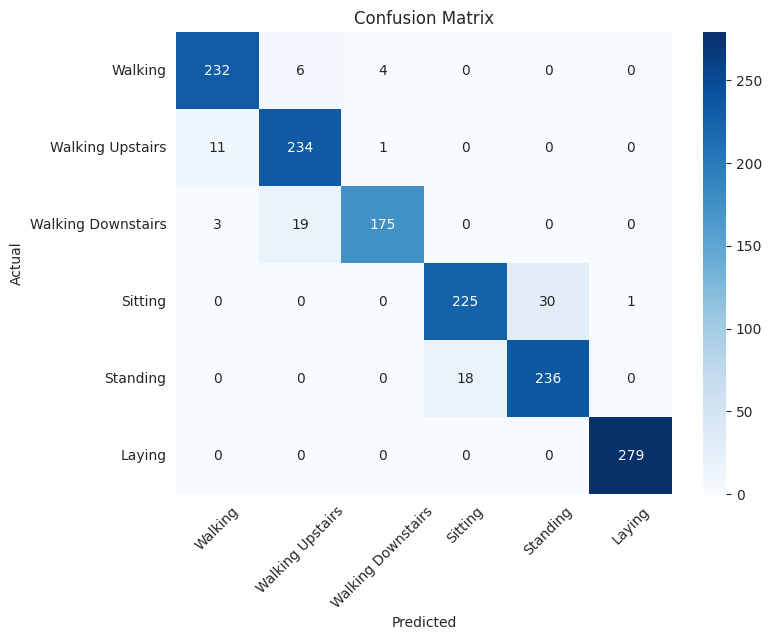

In [36]:
# Convert labels to one-hot encoding for classification problem
y_train_categorical = to_categorical(y_train - 1, num_classes=6)  # y_train has values 1 to 6
y_val_categorical = to_categorical(y_val - 1, num_classes=6)
y_test_categorical = to_categorical(y_test - 1)

# Convert one-hot encoded labels to class indices
y_train_classes = np.argmax(y_train_categorical, axis=1)
y_val_classes = np.argmax(y_val_categorical, axis=1)
y_test_classes = np.argmax(y_test_categorical, axis=1)

# Initialize the SVM model
svm_pca = svm.SVC(kernel='rbf', C=1, gamma='scale')

# Fit the SVM model with the correct format for y
svm_pca.fit(X_train_pca, y_train_classes)

# Record the start time for inference
start_time = time.time()

# Make predictions
y_pred_svm = svm_pca.predict(X_test_pca)

# Record the end time for inference
end_time = time.time()

# Calculate total time taken for inference
total_inference_time = end_time - start_time

# Calculate average time per sample
average_inference_time = total_inference_time / len(X_test_pca)
model_size = sys.getsizeof(svm_pca)
print(f"Random Forest model size: {model_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")

# Calculate accuracy and other metrics
accuracy = accuracy_score(y_test_classes, y_pred_svm)
print(f"Accuracy: {accuracy:.2f}")

precision = precision_score(y_test_classes, y_pred_svm, average='weighted')
print(f"Precision: {precision:.2f}")

recall = recall_score(y_test_classes, y_pred_svm, average='weighted')
print(f"Recall: {recall:.2f}")

f1 = f1_score(y_test_classes, y_pred_svm, average='weighted')
print(f"F1 Score: {f1:.2f}")

# Print classification report
print("Classification Report:")
print(classification_report(y_test_classes, y_pred_svm))

# Compute confusion matrix
conf_matrix = confusion_matrix(y_test_classes, y_pred_svm)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()


## Model 2: Optimising CNN by adding droput and L2 regularization layers

Epoch 1/100
230/230 [==============================] - 2s 4ms/step - loss: 2.3234 - accuracy: 0.5097 - val_loss: 0.3492 - val_accuracy: 0.9369
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.5526 - accuracy: 0.8021 - val_loss: 0.2071 - val_accuracy: 0.9579
Epoch 3/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3774 - accuracy: 0.8682 - val_loss: 0.1840 - val_accuracy: 0.9640
Epoch 4/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3416 - accuracy: 0.8872 - val_loss: 0.1755 - val_accuracy: 0.9667
Epoch 5/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3272 - accuracy: 0.8904 - val_loss: 0.1713 - val_accuracy: 0.9640
Epoch 6/100
230/230 [==============================] - 1s 5ms/step - loss: 0.3050 - accuracy: 0.9034 - val_loss: 0.1617 - val_accuracy: 0.9681
Epoch 7/100
230/230 [==============================] - 1s 4ms/step - loss: 0.2905 - accuracy: 0.9068 - val_loss: 0.1598 - val_accuracy: 0.9674

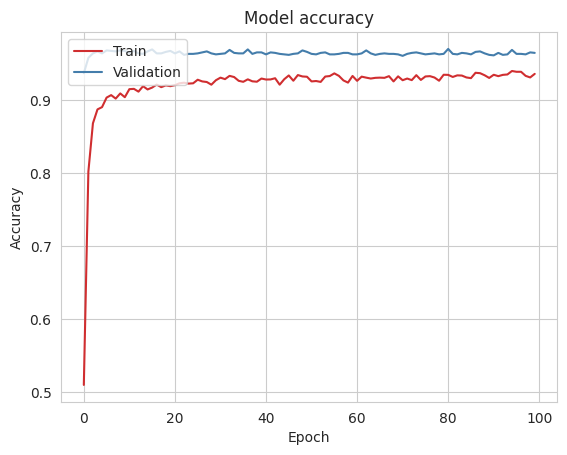

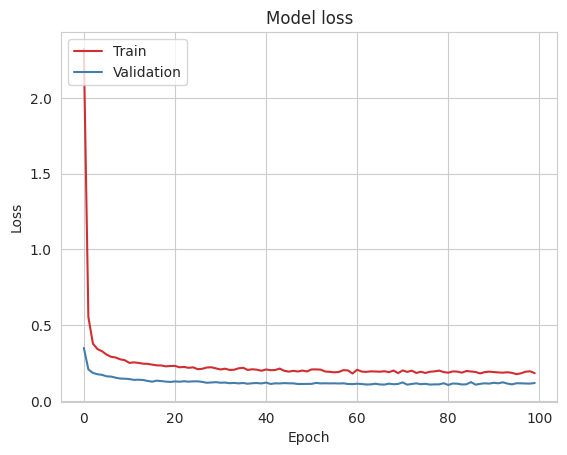

47/47 [==============================] - 0s 3ms/step - loss: 0.1464 - accuracy: 0.9593
Test Loss: 0.1464
Test Accuracy: 0.9593
47/47 [==============================] - 0s 3ms/step


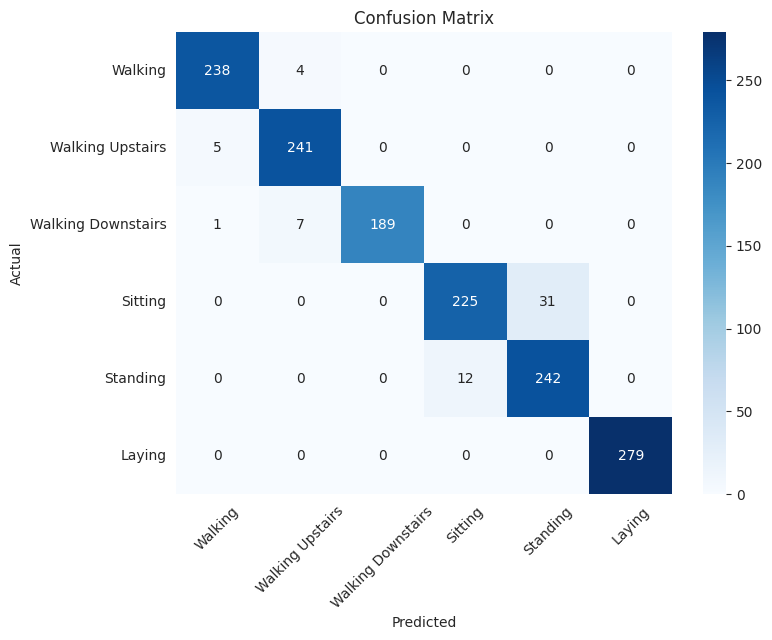

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000272 seconds
Precision: 0.9603
Recall: 0.9593
F1 Score: 0.9593
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       242
           1       0.96      0.98      0.97       246
           2       1.00      0.96      0.98       197
           3       0.95      0.88      0.91       256
           4       0.89      0.95      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



In [37]:
# Define the input shape (5 LDA components)
input_shape_lda = (5,)

# Create a Sequential model
model2_lda = Sequential()

# Add layers to the model, including dropout and regularization
model2_lda.add(Input(shape=input_shape_lda))  # This sets the input shape
model2_lda.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # One hidden layer with L2 regularization
model2_lda.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model2_lda.add(Dense(6, activation='softmax'))  # Output layer

optimizer = Adam(clipnorm=1.0, learning_rate=1e-3)

# Compile the model
model2_lda.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using one-hot encoded labels
history2_lda = model2_lda.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical), epochs=100, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history2_lda.history['accuracy'])
plt.plot(history2_lda.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history2_lda.history['loss'])
plt.plot(history2_lda.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model2_lda.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model2_lda.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model2_size = sys.getsizeof(model2_lda)
print(f"CNN model size: {model2_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

## Model 3: Adding batch normalization layer and gradient clipping to optimizer

Epoch 1/100
230/230 [==============================] - 4s 6ms/step - loss: 1.3378 - accuracy: 0.5288 - val_loss: 0.4131 - val_accuracy: 0.9566
Epoch 2/100
230/230 [==============================] - 1s 4ms/step - loss: 0.4830 - accuracy: 0.8660 - val_loss: 0.2356 - val_accuracy: 0.9667
Epoch 3/100
230/230 [==============================] - 1s 4ms/step - loss: 0.3046 - accuracy: 0.9237 - val_loss: 0.1707 - val_accuracy: 0.9661
Epoch 4/100
230/230 [==============================] - 2s 7ms/step - loss: 0.2240 - accuracy: 0.9430 - val_loss: 0.1471 - val_accuracy: 0.9667
Epoch 5/100
230/230 [==============================] - 2s 8ms/step - loss: 0.1808 - accuracy: 0.9580 - val_loss: 0.1390 - val_accuracy: 0.9640
Epoch 6/100
230/230 [==============================] - 1s 6ms/step - loss: 0.1540 - accuracy: 0.9591 - val_loss: 0.1368 - val_accuracy: 0.9606
Epoch 7/100
230/230 [==============================] - 2s 8ms/step - loss: 0.1412 - accuracy: 0.9623 - val_loss: 0.1271 - val_accuracy: 0.9640

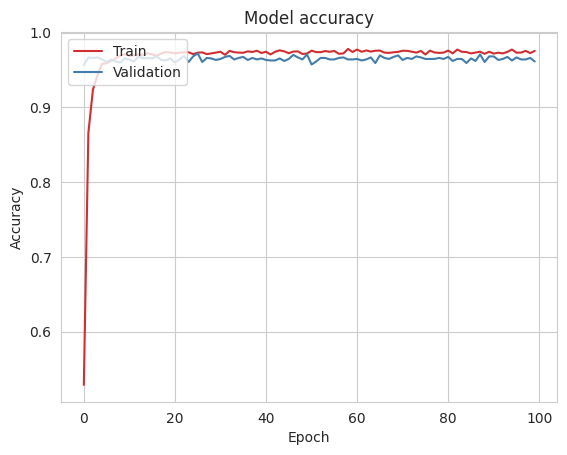

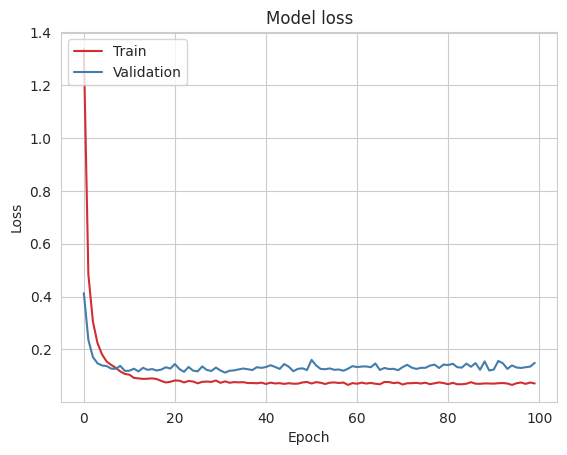

47/47 [==============================] - 0s 2ms/step - loss: 0.1827 - accuracy: 0.9579
Test Loss: 0.1827
Test Accuracy: 0.9579
47/47 [==============================] - 0s 2ms/step


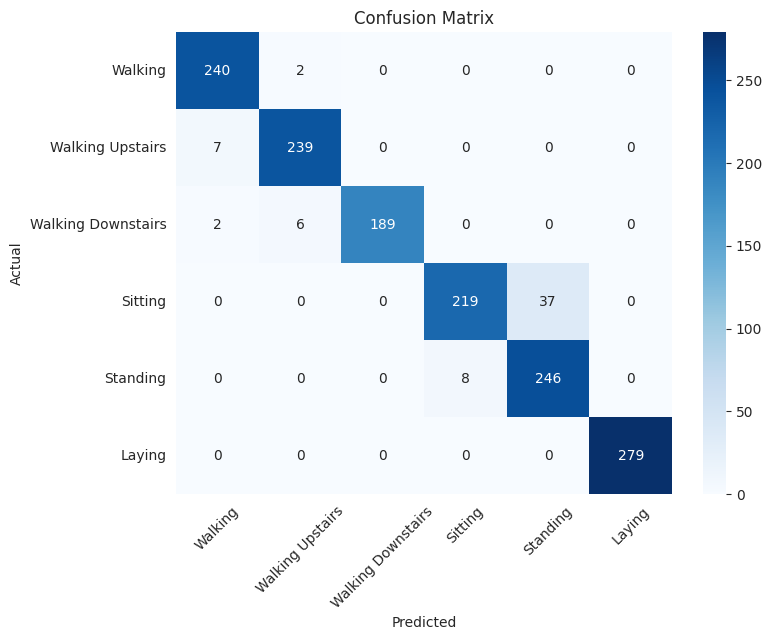

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000199 seconds
Precision: 0.9600
Recall: 0.9579
F1 Score: 0.9579
              precision    recall  f1-score   support

           0       0.96      0.99      0.98       242
           1       0.97      0.97      0.97       246
           2       1.00      0.96      0.98       197
           3       0.96      0.86      0.91       256
           4       0.87      0.97      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



In [38]:
# Define the input shape (5 LDA components)
input_shape_lda = (5,)

# Create a Sequential model
model3_lda = Sequential()

# Add layers to the model, including dropout and regularization
model3_lda.add(Input(shape=input_shape_lda))  # This sets the input shape
model3_lda.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # One hidden layer with L2 regularization
model3_lda.add(BatchNormalization())  # Batch normalization layer
model3_lda.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model3_lda.add(Dense(6, activation='softmax'))  # Output layer

optimizer = Adam(clipnorm=1.0, learning_rate=1e-3)

# Compile the model
model3_lda.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model using one-hot encoded labels
history3_lda = model3_lda.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical), epochs=100, batch_size=32)

# Plot training & validation accuracy values
plt.plot(history3_lda.history['accuracy'])
plt.plot(history3_lda.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history3_lda.history['loss'])
plt.plot(history3_lda.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model3_lda.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model3_lda.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model3_size = sys.getsizeof(model3_lda)
print(f"CNN model size: {model3_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

## Model 4: Adding early stopping and dynamic learning rate

Epoch 1/100
230/230 [==============================] - 4s 6ms/step - loss: 1.0852 - accuracy: 0.6322 - val_loss: 0.3591 - val_accuracy: 0.9552 - lr: 0.0010
Epoch 2/100
230/230 [==============================] - 1s 3ms/step - loss: 0.4429 - accuracy: 0.8672 - val_loss: 0.2160 - val_accuracy: 0.9681 - lr: 0.0010
Epoch 3/100
230/230 [==============================] - 2s 7ms/step - loss: 0.2918 - accuracy: 0.9274 - val_loss: 0.1571 - val_accuracy: 0.9695 - lr: 0.0010
Epoch 4/100
230/230 [==============================] - 2s 8ms/step - loss: 0.2213 - accuracy: 0.9429 - val_loss: 0.1274 - val_accuracy: 0.9742 - lr: 0.0010
Epoch 5/100
230/230 [==============================] - 1s 5ms/step - loss: 0.1743 - accuracy: 0.9555 - val_loss: 0.1132 - val_accuracy: 0.9735 - lr: 0.0010
Epoch 6/100
230/230 [==============================] - 1s 6ms/step - loss: 0.1434 - accuracy: 0.9627 - val_loss: 0.1097 - val_accuracy: 0.9688 - lr: 0.0010
Epoch 7/100
230/230 [==============================] - 1s 5ms/st

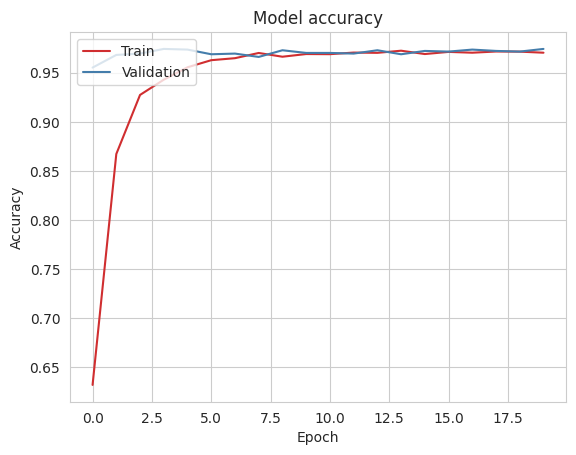

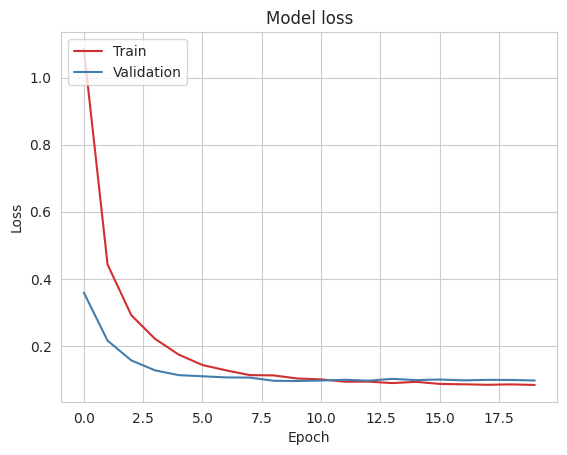

47/47 [==============================] - 0s 7ms/step - loss: 0.1288 - accuracy: 0.9634
Test Loss: 0.1288
Test Accuracy: 0.9634
47/47 [==============================] - 0s 3ms/step


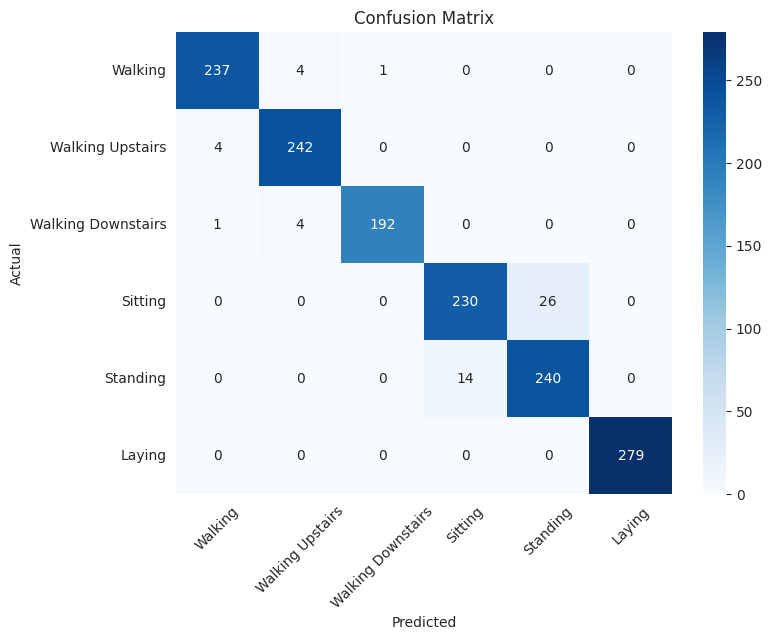

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000381 seconds
Precision: 0.9638
Recall: 0.9634
F1 Score: 0.9634
              precision    recall  f1-score   support

           0       0.98      0.98      0.98       242
           1       0.97      0.98      0.98       246
           2       0.99      0.97      0.98       197
           3       0.94      0.90      0.92       256
           4       0.90      0.94      0.92       254
           5       1.00      1.00      1.00       279

    accuracy                           0.96      1474
   macro avg       0.96      0.96      0.96      1474
weighted avg       0.96      0.96      0.96      1474



In [39]:
# Define the input shape (5 LDA components)
input_shape_lda = (5,)

# Create a Sequential model
model4_lda = Sequential()

# Add layers to the model, including dropout and regularization
model4_lda.add(Input(shape=input_shape_lda))  # This sets the input shape
model4_lda.add(Dense(16, activation='relu', kernel_regularizer=l2(0.01)))  # One hidden layer with L2 regularization
model4_lda.add(BatchNormalization())  # Batch normalization layer
model4_lda.add(Dropout(0.5))  # Dropout layer to prevent overfitting
model4_lda.add(Dense(6, activation='softmax'))  # Output layer

# Define the optimizer with gradient clipping
optimizer = Adam(clipnorm=1.0, learning_rate=1e-3)

# Compile the model
model4_lda.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train the model using one-hot encoded labels with callbacks
history4_lda = model4_lda.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical), 
                              epochs=100, batch_size=32, callbacks=[early_stopping, reduce_lr])

# Plot training & validation accuracy values
plt.plot(history4_lda.history['accuracy'])
plt.plot(history4_lda.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history4_lda.history['loss'])
plt.plot(history4_lda.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model4_lda.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model4_lda.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model4_size = sys.getsizeof(model4_lda)
print(f"CNN model size: {model4_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

## Model 5: Hyperparameter tuning using bayesian inference

In [60]:
# Define the model-building function as a HyperModel subclass
class Model5(HyperModel):
    def build(self, hp):
        model = Sequential()
        model.add(Input(shape=(5,)))
        model.add(Dense(16, activation='relu', kernel_regularizer=l2(hp.Float('l2', 1e-5, 1e-1, sampling='log'))))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout', 0.2, 0.5)))
        model.add(Dense(6, activation='softmax'))

        optimizer = Adam(
            learning_rate=hp.Float('learning_rate', 1e-6, 1e-2, sampling='log'),
            clipnorm=hp.Float('clipnorm', 0.5, 3.0)
        )

        model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
        return model

Trial 20 Complete [00h 00m 58s]
val_accuracy: 0.9708078801631927

Best val_accuracy So Far: 0.973862886428833
Total elapsed time: 00h 36m 18s

The optimal hyperparameters are:
- Dropout rate: 0.3001976261305462
- L2 regularizer: 0.1
- Clipnorm: 3.0
- Learning rate: 0.01

Epoch 1/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 6s 9ms/step - accuracy: 0.8371 - loss: 0.7608 - val_accuracy: 0.9633 - val_loss: 0.1744 - learning_rate: 0.0100
Epoch 2/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9706 - loss: 0.1312 - val_accuracy: 0.9348 - val_loss: 0.2466 - learning_rate: 0.0100
Epoch 3/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - accuracy: 0.9688 - loss: 0.1284 - val_accuracy: 0.9627 - val_loss: 0.1502 - learning_rate: 0.0100
Epoch 4/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.9710 - loss: 0.1113 - val_accuracy: 0.9667 - val_loss: 0.1466 - learning_rate: 0.0100
Epoch 5/100
230/230 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.9710 - loss: 0.1132 - val_accuracy: 0.9667 - val_

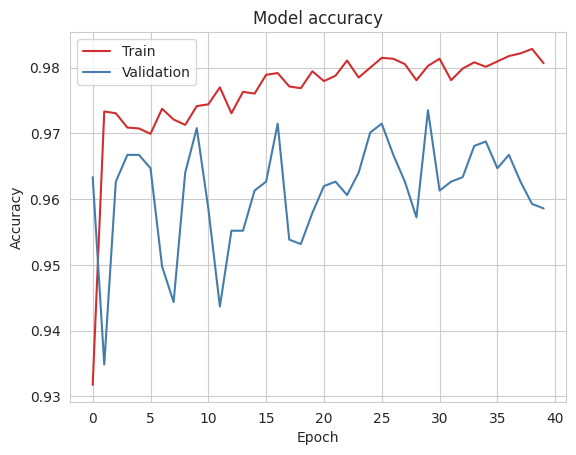

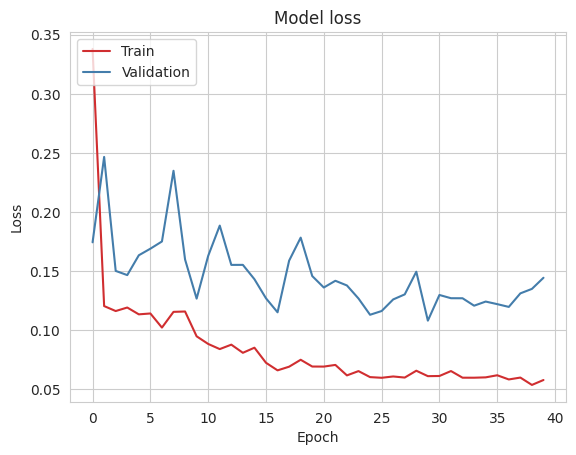

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9726 - loss: 0.1191
Test Loss: 0.1336
Test Accuracy: 0.9695
47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


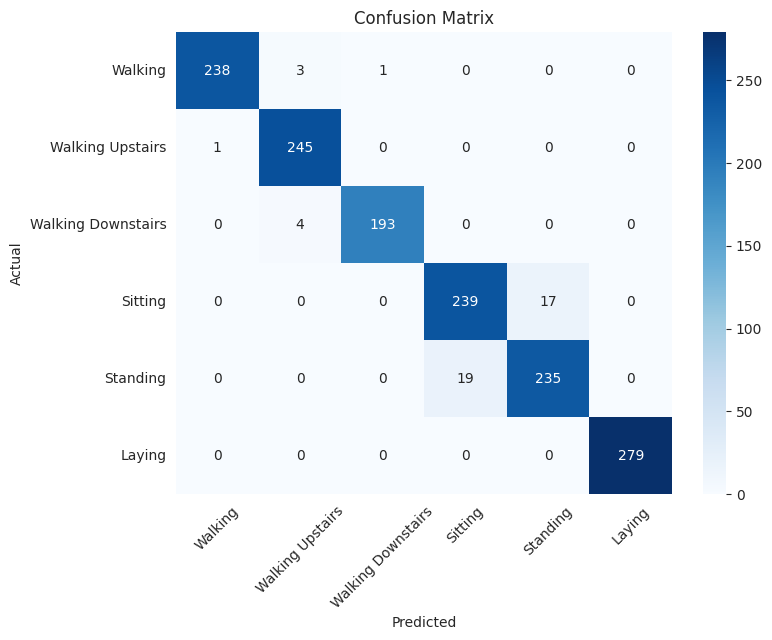

CNN model size: 0.000053 MB
Average Inference Time per Sample: 0.000377 seconds
Precision: 0.9696
Recall: 0.9695
F1 Score: 0.9695
              precision    recall  f1-score   support

           0       1.00      0.98      0.99       242
           1       0.97      1.00      0.98       246
           2       0.99      0.98      0.99       197
           3       0.93      0.93      0.93       256
           4       0.93      0.93      0.93       254
           5       1.00      1.00      1.00       279

    accuracy                           0.97      1474
   macro avg       0.97      0.97      0.97      1474
weighted avg       0.97      0.97      0.97      1474



In [61]:
tuner = BayesianOptimization(
    Model5(),
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=2,
    directory='hyperparameter_search',
    project_name='bayesian_opt'
)

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Perform hyperparameter search
tuner.search(X_train_lda, y_train_categorical, epochs=50, validation_data=(X_val_lda, y_val_categorical), batch_size=32,
             callbacks=[early_stopping, reduce_lr])

# Retrieve the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""
The optimal hyperparameters are:
- Dropout rate: {best_hps.get('dropout')}
- L2 regularizer: {best_hps.get('l2')}
- Clipnorm: {best_hps.get('clipnorm')}
- Learning rate: {best_hps.get('learning_rate')}
""")

# Build and train the model with the best hyperparameters
model5_lda = tuner.hypermodel.build(best_hps)
history5_lda = model5_lda.fit(X_train_lda, y_train_categorical, epochs=100, validation_data=(X_val_lda, y_val_categorical), batch_size=32, 
                              callbacks=[early_stopping, reduce_lr])

# Plot training & validation accuracy values
plt.plot(history5_lda.history['accuracy'])
plt.plot(history5_lda.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history5_lda.history['loss'])
plt.plot(history5_lda.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = model5_lda.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = model5_lda.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

model5_size = sys.getsizeof(model5_lda)
print(f"CNN model size: {model5_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))

## Model 6: Prune and Quantizized

In [ ]:
'''# Define the model architecture
model6_ldr = Sequential([
    Input(shape=(5,)),
    Dense(16, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.312),
    Dense(6, activation='softmax')
])

# Apply pruning
pruning_params = {
    'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(
        initial_sparsity=0.50, final_sparsity=0.80, begin_step=0, end_step=1000)
}
model_for_pruning = tfmot.sparsity.keras.prune_low_magnitude(model6_ldr, **pruning_params)

# Compile the pruned model
optimizer = Adam(clipnorm=2.0, learning_rate=0.004878)
model_for_pruning.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-8)

# Train the pruned model
callbacks = [tfmot.sparsity.keras.UpdatePruningStep(), early_stopping, reduce_lr]
history = model_for_pruning.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical),
                                epochs=100, batch_size=32, callbacks=callbacks)

# Strip pruning wrappers
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

# Define a custom QuantizeConfig for BatchNormalization
class Default8BitQuantizeConfig(tfmot.quantization.keras.QuantizeConfig):
    def get_weights_and_quantizers(self, layer):
        return []

    def get_activations_and_quantizers(self, layer):
        return []

    def set_quantize_weights(self, layer, quantize_weights):
        pass

    def set_quantize_activations(self, layer, quantize_activations):
        pass

    def get_output_quantizers(self, layer):
        return [tfmot.quantization.keras.quantizers.MovingAverageQuantizer(
            num_bits=8, per_axis=False, symmetric=False, narrow_range=False)]

    def get_config(self):
        return {}
    
def apply_quantization_to_layers(layer):
    if isinstance(layer, BatchNormalization):
        return tfmot.quantization.keras.quantize_annotate_layer(layer, Default8BitQuantizeConfig())
    return layer

# Manually annotate the layers
annotated_model = Sequential()
for layer in model_for_export.layers:
    annotated_model.add(apply_quantization_to_layers(layer))

annotated_model.build(input_shape=(None, 5))

# Apply quantization
quant_aware_model = tfmot.quantization.keras.quantize_apply(annotated_model)

# Compile the quantization-aware model
quant_aware_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Train the quantization-aware model
q_aware_history = quant_aware_model.fit(X_train_lda, y_train_categorical, validation_data=(X_val_lda, y_val_categorical),
                                        epochs=100, batch_size=32, callbacks=callbacks)

# Plot training & validation accuracy values
plt.plot(q_aware_history.history['accuracy'])
plt.plot(q_aware_history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(q_aware_history.history['loss'])
plt.plot(q_aware_history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Evaluate the model on the test set
loss, accuracy = quant_aware_model.evaluate(X_test_lda, y_test_categorical)
print(f'Test Loss: {loss:.4f}\nTest Accuracy: {accuracy:.4f}')

# Record start time for inference
start_time = time.time()

# Get predictions
y_pred = quant_aware_model.predict(X_test_lda)

# Record end time for inference
end_time = time.time()

# Calculate total and average inference time
total_inference_time = end_time - start_time
average_inference_time = total_inference_time / len(X_test_lda)

y_pred_classes = np.argmax(y_pred, axis=1)  # Get class labels
y_true_classes = np.argmax(y_test_categorical, axis=1)

# Compute confusion matrix
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Plot confusion matrix with descriptive labels
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=list(label_mapping.values()), 
            yticklabels=list(label_mapping.values()))
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.xticks(rotation=45)
plt.title('Confusion Matrix')
plt.show()

# Calculate and print metrics
precision = precision_score(y_true_classes, y_pred_classes, average='weighted')  # Change to 'macro' or 'micro' as needed
recall = recall_score(y_true_classes, y_pred_classes, average='weighted')
f1 = f1_score(y_true_classes, y_pred_classes, average='weighted')

q_aware_model_size = sys.getsizeof(quant_aware_model)
print(f"CNN model size: {q_aware_model_size / (1024 ** 2):.6f} MB")

print(f"Average Inference Time per Sample: {average_inference_time:.6f} seconds")
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')
print(f'F1 Score: {f1:.4f}')

print(classification_report(y_true_classes, y_pred_classes))'''

Epoch 1/100
230/230 [==============================] - 5s 7ms/step - loss: 0.6311 - accuracy: 0.8308 - val_loss: 0.3166 - val_accuracy: 0.9369 - lr: 0.0049
Epoch 2/100
230/230 [==============================] - 2s 10ms/step - loss: 0.2662 - accuracy: 0.9270 - val_loss: 0.1772 - val_accuracy: 0.9532 - lr: 0.0049
Epoch 3/100
230/230 [==============================] - 2s 9ms/step - loss: 0.2930 - accuracy: 0.9008 - val_loss: 0.2471 - val_accuracy: 0.9314 - lr: 0.0049
Epoch 4/100
230/230 [==============================] - 2s 10ms/step - loss: 0.2999 - accuracy: 0.8916 - val_loss: 0.2232 - val_accuracy: 0.9348 - lr: 0.0049
Epoch 5/100
230/230 [==============================] - 2s 9ms/step - loss: 0.3013 - accuracy: 0.8853 - val_loss: 0.2230 - val_accuracy: 0.9369 - lr: 0.0049
Epoch 6/100
230/230 [==============================] - 2s 10ms/step - loss: 0.2738 - accuracy: 0.8950 - val_loss: 0.2234 - val_accuracy: 0.9437 - lr: 0.0049
Epoch 7/100
230/230 [==============================] - 2s 10m

ValueError: Unable to clone model. This generally happens if you used custom Keras layers or objects in your model. Please specify them via `quantize_scope` for your calls to `quantize_model` and `quantize_apply`. [Unknown None: 'Default8BitQuantizeConfig'. Please ensure you are using a `keras.utils.custom_object_scope` and that this object is included in the scope. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.].

In [ ]:
'''# Convert to TensorFlow Lite format
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
tflite_model = converter.convert()

# Save the quantized model
with open('model_quantized_aware.tflite', 'wb') as f:
    f.write(tflite_model)'''

## Plot and save model architechture diagrams

In [64]:
plot_model(model_lda, to_file='model_fig/model1_lda_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model_pca, to_file='model_fig/model1_pca_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model2_lda, to_file='model_fig/model2_lda_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model3_lda, to_file='model_fig/model3_lda_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model4_lda, to_file='model_fig/model4_lda_plot.png', show_shapes=True, show_layer_names=True)
plot_model(model5_lda, to_file='model_fig/model5_lda_plot.png', show_shapes=True, show_layer_names=True)
# plot_model(q_aware_model, to_file='model_fig/q_aware_model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.
